# Forecasting Customer Demand with Extreme Outliers

## Load packages and import data

In [6]:
#Locate imported packages
import sys
sys.path

# Reading an excel file using Python
import os

#import pandas and numpy
import pandas as pd
import numpy as np

# From matplotlib, import pyplot under the alias plt
from matplotlib import pyplot as plt

#Import library
from prophet import Prophet
from prophet.plot import plot_yearly, plot_forecast_component, add_changepoints_to_plot
from prophet.utilities import regressor_coefficients

In [4]:
# Give the location of your file -
file = ('datasets/dinner.xlsx')
 
#Load spreadsheet
data = pd.ExcelFile(file)

## Load a sheet into a DataFrame by name
df = data.parse('dinner')

#Check results
print(df.head())

        Date  Cust count dinner
0 2001-06-28                402
1 2001-06-29                573
2 2001-06-30                564
3 2001-07-01                403
4 2001-07-02                275


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1559 non-null   datetime64[ns]
 1   Cust count dinner  1559 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 24.5 KB
None


## Data Prep

In [8]:
#Rename columns
df.rename(columns = {'Date': 'ds', 'Cust count dinner': 'y'},inplace = True)

#Check results of renaming
print(df.columns)

Index(['ds', 'y'], dtype='object')


## Exploratory Data Analysis (EDA)

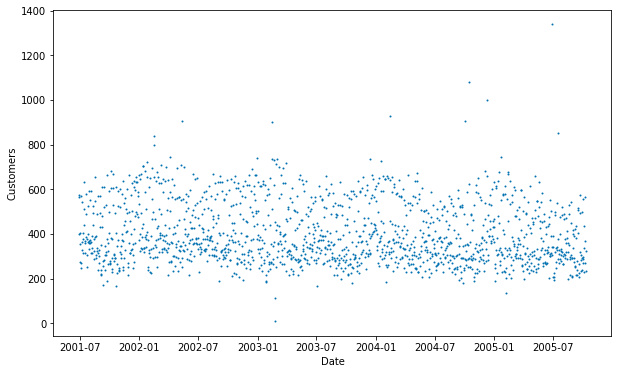

In [9]:
#Number of customers per day
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['ds']), df['y'], s=1, c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Customers')
plt.show()

This visualization shows the number of customers per day.

## Model Fit

In [10]:
#We need to initiate a Prophet object
#m = Prophet(seasonality_mode='multiplicative')
m = Prophet()

#Fit model
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3750.3    0.00148854       126.587           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       3750.64   0.000127312       126.686   9.063e-07       0.001      196  LS failed, Hessian reset 
     171       3750.67   2.74868e-05       76.0323   3.348e-07       0.001      288  LS failed, Hessian reset 
     191       3750.68   8.84013e-08       79.1544      0.2669           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Prophet's default mode for seasonality is additive.

## How did Prophet handle the data

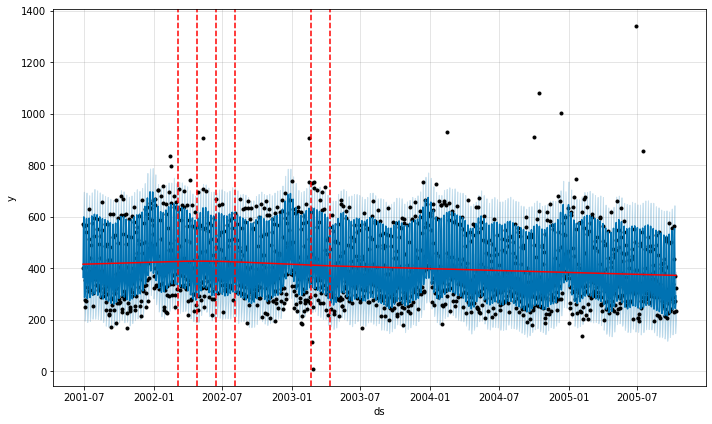

In [11]:
#Create forecast using predict function - if no future dataframe is created then the
#predict function will simply predict values on the historical data that was fit in
#the model
#We just want to see how Prophet handeled seasonality
forecast = m.predict()


fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()

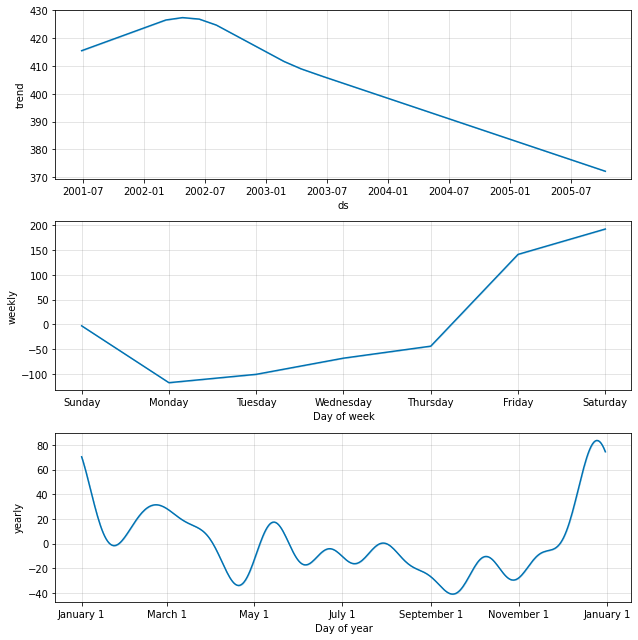

In [12]:
#Components plot
fig2 = m.plot_components(forecast)

There are 3 components: Trend, Weekly, and Yearly. If you have a dataset that has at least two years of data, Prophet will automatically detect and isolate yearly seasonality components. You need at least two weeks of data for weekly seasonality to be included. 

Trend shows that customer demand has been decreasing linearly since mid 2002. The weekly trend shows that demand is highest on Fridays and Saturdays.  The yearly trend is very wavy showing high peak demand in December/January. Fourier series is how seasonality is controlled and if we wanted to control the waviness, we could change the fourier order.

## Create Future Forecast

In [20]:
#Make future dataframe 
#Period equals 365 days times 1
#This means we want to predict customers one year into the future.
future = m.make_future_dataframe(periods=365 * 1)
future_forecast = m.predict(future)

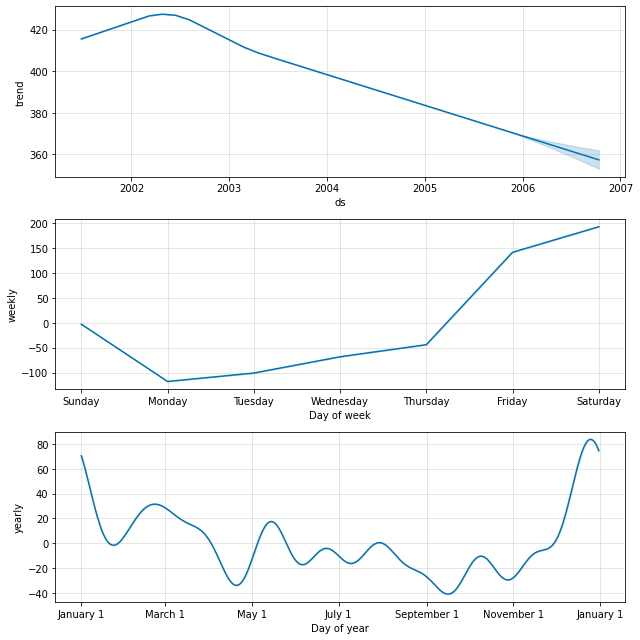

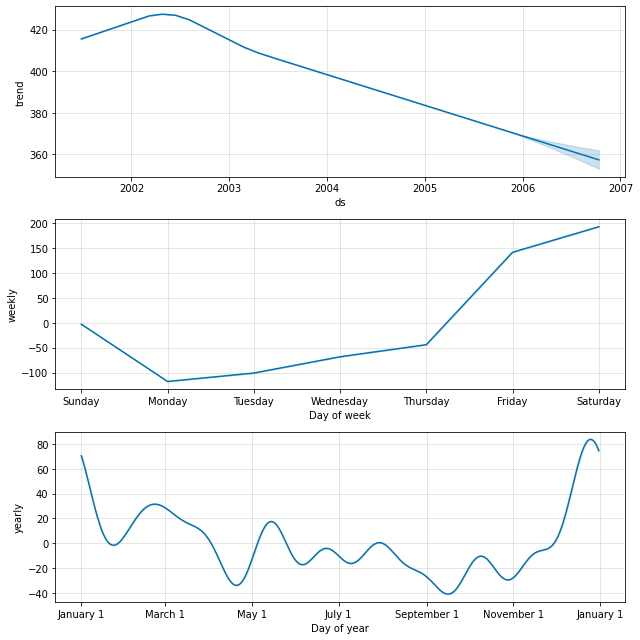

In [15]:
m.plot_components(future_forecast)

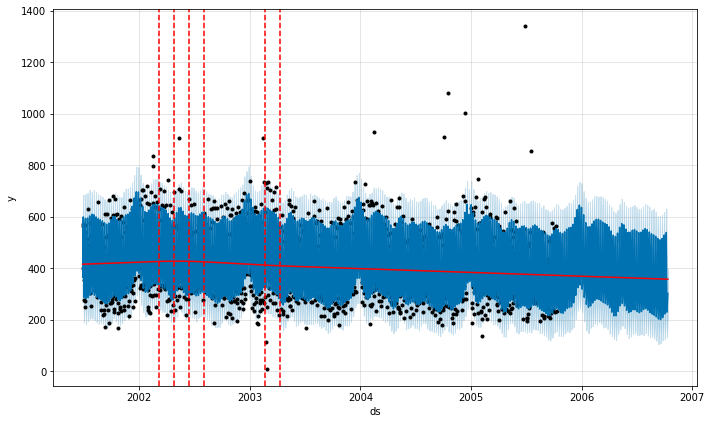

In [14]:
#Plot the forecast with changepoints.
fig2 = m.plot(future_forecast)
add_changepoints_to_plot(fig2.gca(), m, future_forecast)
plt.show()

# Model Performance

In [16]:
from prophet.diagnostics import cross_validation

Horizon is the length of time to evaluate the forecast (the time we want to predict).

Initial is the first training period (which the data will be trained on).

Period is the amount of time between each fold.

Cutoffs are the dates where each horizon will begin. Not really necessary.


In [17]:
df_cv = cross_validation(m,
                         horizon='90 days',
                         period='30 days',
                         initial='730 days',
                        parallel='processes')

INFO:prophet:Making 25 forecasts with cutoffs between 2003-07-25 00:00:00 and 2005-07-14 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc847eaf580>


Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1639.75   0.000376507       93.7809     0.07195           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.2406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       1639.79   1.50551e-06       66.3726   1.919e-08       0.001      237  LS failed, Hessian reset 
     159       1639.79   7.24118e-08       66.1907      0.5764      0.5764      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1708.25    0.00112328        65.987           1           1      118   
    Iter      log prob        |

      91       2440.18   0.000206198       69.2442   1.682e-06       0.001      155  LS failed, Hessian reset 
      99       2440.25   0.000144622       63.2815      0.4707      0.7538      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       2440.26   9.26333e-08       66.9913      0.4581      0.4581      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.6712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2511.45   0.000185311       66.5639      0.9493      0.9493      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       2511.51   6.06809e-05       75.4227   7.542e-07       0.0

     173        3515.7   3.17761e-07       64.9043      0.3332      0.3332      218   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [18]:
#Print cross-validated df
print(df_cv.head())

          ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 2003-07-26  598.983113  504.713567  691.617881  520 2003-07-25
1 2003-07-27  398.117418  313.504132  484.762559  389 2003-07-25
2 2003-07-28  273.095349  185.219537  364.791358  337 2003-07-25
3 2003-07-29  290.617346  200.283719  371.923804  309 2003-07-25
4 2003-07-30  316.852897  232.725259  403.190347  342 2003-07-25


In [19]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,4751.319664,68.929817,50.469283,0.130011,0.098791,0.129599,0.841973
1,11 days,4579.951727,67.675341,51.040203,0.137273,0.101192,0.134004,0.833004
2,12 days,4343.602179,65.906010,49.874170,0.134617,0.100909,0.130879,0.846786
3,13 days,4092.167099,63.970048,48.837269,0.131694,0.095797,0.127957,0.842511
4,14 days,4417.133185,66.461517,50.215213,0.138612,0.099494,0.133115,0.843049


/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


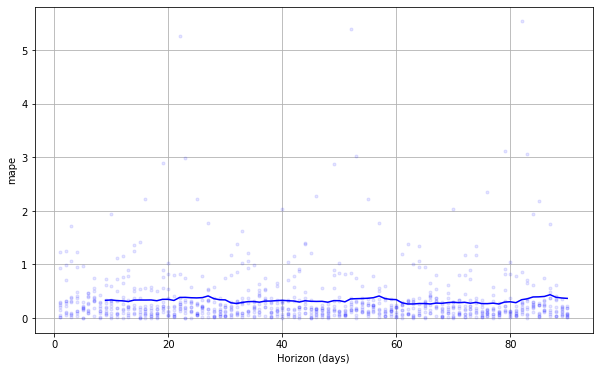

In [26]:
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape')


Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots.

In [22]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       3675.51   2.99609e-07       4962.31   5.992e-11       0.001      145  LS failed, Hessian reset 
      94       3675.51   9.43462e-09       4963.09      0.6037      0.6037      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc844da9760>


Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       667.303   1.67386e-09       5030.59     0.04486     0.04486       93   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94        724.53   7.54911e-09       4851.76      0.1742      0.1742      124   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       703.981   6.61504e-09       5005.05      0.2203      0.2203       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabi

Initial log joint probability = -10.7348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.7348             0       456.741       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -182.927
Iteration  1. Log joint probability =     433.17. Improved by 600.451.


Initial log joint probability = -7.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    668.248. Improved by 235.079.
Iteration  1. Log joint probability =    402.571. Improved by 585.498.
      84       875.921   0.000129345       4835.63   2.529e-08       0.001      138  LS failed, Hessian reset 
      99       876.855   2.30822e-06       4692.64      0.5855      0.5855      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       876.877   5.73581e-09       4798.94      0.8824      0.8824      194   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    675.352. Improved by 7.10345.
Iteration  2. Log joint probability =    649.958. Improved by 247.387.
Iteration  4. Log joint probability =    735.238. Improved by 59.8863.
Iteration  3. Log joint probab

Iteration 32. Log joint probability =    808.067. Improved by 4.62787e-06.
Iteration 27. Log joint probability =     844.05. Improved by 2.42281e-05.
Iteration  1. Log joint probability =     317.02. Improved by 528.784.
Iteration 33. Log joint probability =    808.067. Improved by 2.62315e-06.
Iteration 28. Log joint probability =     844.05. Improved by 4.46729e-06.
Iteration 34. Log joint probability =    808.067. Improved by 8.74849e-07.
Iteration  2. Log joint probability =    692.289. Improved by 375.27.
Iteration 29. Log joint probability =     844.05. Improved by 1.52415e-05.
Iteration 35. Log joint probability =    808.067. Improved by 8.2116e-09.
Initial log joint probability = -10.2233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.2233             0       498.642       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be

Iteration 30. Log joint probability =     844.05. Improved by 5.15858e-06.

Initial log joint probability = -223.768
Iteration 31. Log joint probability =     844.05. Improved by 6.561e-06.
Iteration  4. Log joint probability =    888.677. Improved by 8.35912.
Iteration  1. Log joint probability =    357.893. Improved by 581.661.
Iteration  5. Log joint probability =    903.009. Improved by 14.3318.
Iteration 32. Log joint probability =     844.05. Improved by 1.63351e-06.
Iteration  2. Log joint probability =    771.921. Improved by 414.028.
Iteration  6. Log joint probability =     905.27. Improved by 2.26116.
Iteration 33. Log joint probability =     844.05. Improved by 4.07604e-06.
Iteration  7. Log joint probability =    908.893. Improved by 3.62281.
Iteration 34. Log joint probability =     844.05. Improved by 2.24859e-07.
Iteration  3. Log joint probability =    905.713. Improved by 133.793.
Iteration  8. Log joint probability =    909.529. Improved by 0.636591.
Iteration 35. Lo

Iteration  1. Log joint probability =    450.662. Improved by 729.173.
Iteration  2. Log joint probability =    661.733. Improved by 211.071.
Iteration  3. Log joint probability =    934.593. Improved by 272.86.
Iteration  4. Log joint probability =     1021.8. Improved by 87.2062.
Iteration  5. Log joint probability =    1022.86. Improved by 1.06114.
Iteration  6. Log joint probability =     1039.3. Improved by 16.4392.
Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -15.6942             0       577.013       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -296.321


Iteration  7. Log joint probability =    1039.98. Improved by 0.676526.
Iteration  8. Log joint probability =    1040.99. Improved by 1.01343.
Iteration  1. Log joint probability =    481.415. Improved by 777.736.
Iteration  9. Log joint probability =    1041.39. Improved by 0.3997.
Iteration  2. Log joint probability =    503.782. Improved by 22.3668.
Iteration 10. Log joint probability =    1041.56. Improved by 0.168119.
Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -13.1179             0       587.417       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -307.529


Iteration  3. Log joint probability =    1022.84. Improved by 519.056.
Iteration 11. Log joint probability =    1041.79. Improved by 0.23535.
Iteration 12. Log joint probability =    1041.95. Improved by 0.154966.
Iteration  1. Log joint probability =    527.682. Improved by 835.211.
Iteration  4. Log joint probability =    1062.36. Improved by 39.5249.
Iteration 13. Log joint probability =    1041.95. Improved by 0.00597355.
Iteration  5. Log joint probability =     1065.5. Improved by 3.1337.
Iteration  2. Log joint probability =    828.857. Improved by 301.175.
Iteration 14. Log joint probability =    1042.02. Improved by 0.0668326.
Iteration  6. Log joint probability =    1065.92. Improved by 0.420777.
Iteration 15. Log joint probability =    1042.04. Improved by 0.0205738.
Iteration  3. Log joint probability =    958.235. Improved by 129.378.
Iteration  7. Log joint probability =    1066.35. Improved by 0.437382.
Iteration 16. Log joint probability =    1042.07. Improved by 0.0280

Iteration 14. Log joint probability =    1067.12. Improved by 0.0321085.
Iteration 24. Log joint probability =    1042.11. Improved by 0.000858585.
Iteration 12. Log joint probability =    1096.22. Improved by 0.0880888.
Iteration 25. Log joint probability =    1042.11. Improved by 0.000137862.
Iteration 15. Log joint probability =    1067.12. Improved by 0.00104163.
Iteration  1. Log joint probability =    430.624. Improved by 770.029.
Iteration 13. Log joint probability =    1096.53. Improved by 0.313579.
Iteration 26. Log joint probability =    1042.11. Improved by 0.000574391.
Iteration 16. Log joint probability =    1067.12. Improved by 0.00016679.
Iteration  2. Log joint probability =    761.926. Improved by 331.302.
Iteration 14. Log joint probability =    1096.64. Improved by 0.104183.
Iteration 27. Log joint probability =    1042.11. Improved by 0.000370278.
Iteration 17. Log joint probability =    1067.13. Improved by 0.00702549.
Iteration 15. Log joint probability =    1096.

Iteration 30. Log joint probability =    1097.62. Improved by 0.000136733.
Iteration 43. Log joint probability =    1096.82. Improved by 5.46275e-07.
Iteration 44. Log joint probability =    1067.17. Improved by 1.05071e-05.
Iteration 31. Log joint probability =    1097.62. Improved by 6.27835e-05.
Iteration 44. Log joint probability =    1096.82. Improved by 1.24776e-06.
Iteration 45. Log joint probability =    1067.17. Improved by 6.72585e-06.
Iteration 32. Log joint probability =    1097.62. Improved by 9.43827e-06.
Iteration 45. Log joint probability =    1096.82. Improved by 3.90241e-07.
Iteration 46. Log joint probability =    1067.17. Improved by 3.42842e-06.
Iteration 33. Log joint probability =    1097.62. Improved by 3.1086e-05.
Iteration 46. Log joint probability =    1096.82. Improved by 2.44369e-07.
Iteration 47. Log joint probability =    1067.17. Improved by 1.7101e-06.
Iteration 34. Log joint probability =    1097.62. Improved by 4.64055e-06.
Iteration 47. Log joint pro

Iteration  1. Log joint probability =    562.994. Improved by 957.93.
Iteration  2. Log joint probability =    938.381. Improved by 375.387.
Iteration  3. Log joint probability =    1200.43. Improved by 262.047.
Iteration  4. Log joint probability =    1203.08. Improved by 2.65211.
Iteration  5. Log joint probability =    1226.79. Improved by 23.713.
Iteration  6. Log joint probability =    1226.95. Improved by 0.153175.
Iteration  7. Log joint probability =    1228.22. Improved by 1.27348.
Iteration  8. Log joint probability =    1230.07. Improved by 1.84653.
Iteration  9. Log joint probability =    1231.11. Improved by 1.04201.
Iteration 10. Log joint probability =     1236.5. Improved by 5.39476.
Iteration 11. Log joint probability =    1244.86. Improved by 8.35334.
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 12. Log joint probability =    1249.25. Improved by 4.3912.
      68         

Initial log joint probability = -15.3449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       1560.71   6.08684e-07       4852.58   1.237e-10       0.001      153  LS failed, Hessian reset 
      99       1560.72   3.71538e-08       4472.27           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       1560.72   8.32564e-09        4858.2      0.6134      0.6134      181   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       1581.97   5.80289e-09       5050.31      0.3524      0.3524       96   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.4144
    Iter      log p


Initial log joint probability = -579.266
Iteration  1. Log joint probability =    589.395. Improved by 1168.66.
Iteration  2. Log joint probability =    1181.83. Improved by 592.438.
Iteration  3. Log joint probability =    1607.65. Improved by 425.82.
Iteration  4. Log joint probability =    1638.31. Improved by 30.6603.
Iteration  5. Log joint probability =    1646.59. Improved by 8.2761.
Iteration  6. Log joint probability =     1662.4. Improved by 15.8097.
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  7. Log joint probability =    1671.71. Improved by 9.30764.
      99       1704.85    0.00109865       5259.12      0.3803      0.3803      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       1710.75   7.00428e-09       4509.24      0.2482      0.2482      200   
Optimization terminated normally: 
  Convergence detected: absol

Iteration 56. Log joint probability =    1684.53. Improved by 9.49552e-07.
Iteration 57. Log joint probability =    1684.53. Improved by 4.1694e-08.
Iteration 58. Log joint probability =    1684.53. Improved by 6.30621e-09.
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       2044.58   0.000133215       5077.29   2.611e-08       0.001      159  LS failed, Hessian reset 
      99       2045.12   3.23839e-05       4892.68      0.2296           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       2045.41   1.46783e-05       4997.03    2.92e-09       0.001      257  LS failed, Hessian reset 
     199       2045.47   6.40364e-08       3935.78     0.06484     0.06484      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       2045.47   8.02525e-09       4471.18     0.08463 

Iteration  1. Log joint probability =    578.247. Improved by 1495.65.
Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       2606.99   4.62983e-09       4713.14      0.1994      0.1994      126   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    1492.94. Improved by 914.69.
Initial log joint probability = -19.5578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    2166.87. Improved by 673.933.
      99       2634.64   0.000824424       4560.04      0.5042      0.5042      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2638.71   3.95841e-07       4979.75           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 41. Log joint probability =    2384.72. Improved by 1.00261e-05.
      55       2904.07   0.000143456       4071.93   2.971e-08       0.001      104  LS failed, Hessian reset 
      97        2904.8   8.08872e-06       4939.03   1.557e-09       0.001      190  LS failed, Hessian reset 
      99       2904.82   3.35494e-06       4297.86           1           1      192   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 42. Log joint probability =    2384.72. Improved by 4.07475e-06.
     192       2907.46   8.55467e-09       4737.82      0.3071      0.3071      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 43. Log joint probability =    2384.72. Improved by 7.59476e-07.
Initial log joint probability = -13.6528
    Iter

      63       3438.77    7.1752e-09       4820.49      0.4298      0.4298       89   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =    775.752. Improved by 1996.03.
Iteration  2. Log joint probability =    1453.58. Improved by 677.824.
Iteration  3. Log joint probability =     2207.6. Improved by 754.02.
Iteration  4. Log joint probability =     2208.1. Improved by 0.508073.
Iteration  5. Log joint probability =    2209.44. Improved by 1.33938.
Iteration  6. Log joint probability =    2211.11. Improved by 1.66512.
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  7. Log joint probability =     2213.5. Improved by 2.39351.
      95       3463.91    1.0514e-05       5145.21    2.22e-09       0.001      169  LS failed, Hessian reset 
      99       3463.93   2.79471e-06       4975.87           1     

Iteration 82. Log joint probability =    3405.78. Improved by 3.07e-08.
Iteration 83. Log joint probability =    3405.78. Improved by 3.27327e-09.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       3745.11   9.69073e-09       5034.73      0.3677      0.3677       84   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84d6f9eb0>


Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       854.098   5.06713e-09       4872.44      0.3432      0.3432      112   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       765.218   1.58809e-06       4971.84      0.3834           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       765.234   2.55087e-07       5106.44    5.19e-11       0.001      199  LS failed, Hessian reset 
     129       765.235   8.21613e-09       4913.71      0.5108      0.5108      213   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.70718
    Iter      log p


Initial log joint probability = -242.794
Iteration  1. Log joint probability =    446.829. Improved by 673.977.
Initial log joint probability = -7.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       1006.23    7.1921e-09       5071.87      0.3392      0.9947      122   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =    373.299. Improved by 616.094.
Iteration  2. Log joint probability =    576.319. Improved by 129.49.
Iteration  3. Log joint probability =    833.573. Improved by 257.254.
Iteration  2. Log joint probability =    688.989. Improved by 315.69.
Iteration  4. Log joint probability =     921.41. Improved by 87.8369.
Iteration  3. Log joint probability =    920.987. Improved by 231.997.
Iteration  5. Log joint probability =    926.376. Improved by 4.96664.
Iteration  4. Log joint probability =    974.231. Improved by 53.24

Iteration 23. Log joint probability =    983.903. Improved by 2.48557e-06.
Iteration 31. Log joint probability =     946.04. Improved by 9.8011e-08.
Iteration  1. Log joint probability =    463.831. Improved by 735.463.
Iteration 24. Log joint probability =    983.903. Improved by 1.68065e-05.
Iteration 32. Log joint probability =     946.04. Improved by 4.7296e-06.
Iteration 33. Log joint probability =     946.04. Improved by 2.4915e-07.
Iteration 25. Log joint probability =    983.903. Improved by 3.19084e-06.
Iteration  2. Log joint probability =    751.655. Improved by 287.824.
Iteration 34. Log joint probability =     946.04. Improved by 2.0994e-06.
Iteration 26. Log joint probability =    983.904. Improved by 1.61001e-05.
Initial log joint probability = -10.2233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.2233             0       498.642       1e-12       0.001       27   
Optimization terminated with error: 
  Lin


Initial log joint probability = -283.635
Iteration 35. Log joint probability =     946.04. Improved by 4.51734e-07.
Iteration 27. Log joint probability =    983.904. Improved by 3.8961e-06.
Iteration 36. Log joint probability =     946.04. Improved by 9.23233e-07.
Iteration  4. Log joint probability =     1040.5. Improved by 5.76181.
Iteration  1. Log joint probability =    465.374. Improved by 749.009.
Iteration 28. Log joint probability =    983.904. Improved by 1.53936e-05.
Iteration 37. Log joint probability =     946.04. Improved by 1.58248e-07.
Iteration  5. Log joint probability =    1042.47. Improved by 1.97116.
Iteration  2. Log joint probability =     834.94. Improved by 369.566.
Iteration 29. Log joint probability =    983.904. Improved by 4.60138e-06.
Iteration 38. Log joint probability =     946.04. Improved by 4.56286e-07.
Iteration  6. Log joint probability =    1042.74. Improved by 0.269197.
Iteration 39. Log joint probability =     946.04. Improved by 1.53127e-07.
Ite

Iteration 40. Log joint probability =    1052.88. Improved by 4.26803e-09.
Iteration 36. Log joint probability =    1087.22. Improved by 0.011674.
Iteration 59. Log joint probability =    983.904. Improved by 5.18369e-06.
Iteration 37. Log joint probability =    1087.22. Improved by 0.00406702.
Iteration 60. Log joint probability =    983.904. Improved by 1.40276e-05.
Iteration 38. Log joint probability =    1087.23. Improved by 0.00188478.
Initial log joint probability = -7.82831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 61. Log joint probability =    983.904. Improved by 6.01301e-06.
      87       1102.45   3.28939e-05       5126.94   6.522e-09       0.001      151  LS failed, Hessian reset 
Iteration 39. Log joint probability =    1087.23. Improved by 0.000230609.
      99       1102.59   3.04571e-06       5161.48      0.6803      0.6803      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0

Iteration  1. Log joint probability =    515.866. Improved by 854.246.
Iteration 111. Log joint probability =    983.904. Improved by 6.74759e-08.
Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -15.6942             0       577.013       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -356.188


Iteration 112. Log joint probability =    983.904. Improved by 4.91062e-06.
Iteration  2. Log joint probability =     852.98. Improved by 337.113.
Iteration 113. Log joint probability =    983.904. Improved by 2.00383e-05.
Iteration  1. Log joint probability =    125.609. Improved by 481.797.
Iteration  3. Log joint probability =    1137.23. Improved by 284.252.
Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -13.1179             0       587.417       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -367.396
Iteration 114. Log joint probability =    983.904. Improved by 7.77287e-08.


Iteration  2. Log joint probability =    391.736. Improved by 266.127.
Iteration  4. Log joint probability =    1151.87. Improved by 14.6409.
Iteration 115. Log joint probability =    983.904. Improved by 2.29724e-06.
Iteration  1. Log joint probability =    520.788. Improved by 888.185.
Iteration  5. Log joint probability =    1153.48. Improved by 1.60328.
Iteration  3. Log joint probability =    813.104. Improved by 421.368.
Iteration 116. Log joint probability =    983.904. Improved by 2.27933e-07.
Iteration  6. Log joint probability =    1170.29. Improved by 16.8182.
Iteration  4. Log joint probability =      821.2. Improved by 8.09632.
Iteration  2. Log joint probability =    958.979. Improved by 438.191.
Iteration 117. Log joint probability =    983.904. Improved by 2.14702e-06.
Iteration  7. Log joint probability =    1176.53. Improved by 6.23529.
Iteration 118. Log joint probability =    983.904. Improved by 3.78122e-07.
Iteration  3. Log joint probability =    1198.89. Improve

Iteration 146. Log joint probability =    983.904. Improved by 2.31236e-06.
Iteration 30. Log joint probability =    1240.95. Improved by 6.39989e-06.
Iteration 34. Log joint probability =    1182.33. Improved by 7.30973e-05.
Iteration 26. Log joint probability =    906.529. Improved by 6.15343.
Iteration 147. Log joint probability =    983.904. Improved by 9.62652e-07.
Iteration 31. Log joint probability =    1240.95. Improved by 2.23948e-05.
Iteration 35. Log joint probability =    1182.33. Improved by 7.3157e-05.
Iteration 27. Log joint probability =    913.501. Improved by 6.9716.
Iteration 148. Log joint probability =    983.904. Improved by 1.65574e-07.
Iteration 32. Log joint probability =    1240.95. Improved by 4.42688e-06.
Iteration 36. Log joint probability =    1182.33. Improved by 3.23854e-05.
Iteration 149. Log joint probability =    983.904. Improved by 6.35208e-07.
Iteration 28. Log joint probability =    916.445. Improved by 2.94397.
Iteration 33. Log joint probability

Iteration 58. Log joint probability =    1208.88. Improved by 0.0688954.
Iteration  1. Log joint probability =    421.278. Improved by 820.55.
Iteration 59. Log joint probability =    1208.89. Improved by 0.00855759.
Iteration  2. Log joint probability =    745.229. Improved by 323.951.
Iteration 60. Log joint probability =    1208.92. Improved by 0.0331376.
Iteration 61. Log joint probability =    1208.93. Improved by 0.00589229.
Iteration  3. Log joint probability =    904.973. Improved by 159.744.
Iteration 62. Log joint probability =    1208.95. Improved by 0.0220963.
Initial log joint probability = -9.56055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    1202.88. Improved by 297.912.
Iteration 63. Log joint probability =    1208.95. Improved by 0.00724833.
      75        1260.9   3.36716e-05       5064.19   6.715e-09       0.001      146  LS failed, Hessian reset 
      99       1261.13   8.42704

Iteration  1. Log joint probability =    527.929. Improved by 982.732.
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       1424.61   9.26336e-09       4723.47      0.2705           1      113   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    1041.99. Improved by 514.06.
Iteration  3. Log joint probability =    1160.69. Improved by 118.699.
Iteration  4. Log joint probability =    1190.02. Improved by 29.3315.
Iteration  5. Log joint probability =     1366.3. Improved by 176.281.
Iteration  6. Log joint probability =    1384.52. Improved by 18.219.
Iteration  7. Log joint probability =    1389.21. Improved by 4.69231.
Iteration  8. Log joint probability =    1400.58. Improved by 11.3689.
Initial log joint probability = -11.645
    Iter      log prob        ||dx||      ||grad||       alpha      a

Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       1748.37   3.08128e-06       4514.08   6.404e-10       0.001      137  LS failed, Hessian reset 
      99       1748.39   6.77833e-07       4626.69      0.9214      0.9214      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       1748.39   8.49263e-09       4523.96      0.2852      0.2852      191   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1775.28   4.30656e-05       5133.31      0.3494      0.3494      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1791.44   0.000170778       5061.94    3.36e-08       0.00

Iteration  1. Log joint probability =    713.225. Improved by 1352.36.
Iteration  2. Log joint probability =    1409.62. Improved by 696.391.
Iteration  3. Log joint probability =    1768.46. Improved by 358.844.
Iteration  4. Log joint probability =    1795.39. Improved by 26.9305.
Iteration  5. Log joint probability =    1804.36. Improved by 8.97337.
Iteration  6. Log joint probability =    1810.17. Improved by 5.80722.
Iteration  7. Log joint probability =     1832.4. Improved by 22.2302.
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  8. Log joint probability =    1834.15. Improved by 1.74895.
      91       1841.37   1.07093e-05       5496.39   2.287e-09       0.001      140  LS failed, Hessian reset 
      99       1841.39   4.10122e-07       4165.17      0.2633      0.6819      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145 

Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       2154.56   0.000136293       4997.76   2.699e-08       0.001      174  LS failed, Hessian reset 
      99       2155.19   5.42082e-05       4797.06       0.962       0.962      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       2183.65   0.000228859       5558.59   4.072e-08       0.001      137  LS failed, Hessian reset 
     162       2155.48   6.30641e-06       4504.01    1.17e-09       0.001      297  LS failed, Hessian reset 
      99       2184.91   1.74334e-06       4166.43           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2155.52   2.12118e-07       


Initial log joint probability = -977.271
Iteration  1. Log joint probability =     830.01. Improved by 1807.28.
Iteration  2. Log joint probability =    1608.28. Improved by 778.27.
Iteration  3. Log joint probability =    2248.99. Improved by 640.712.
Iteration  4. Log joint probability =    2526.25. Improved by 277.257.
Iteration  5. Log joint probability =    2526.82. Improved by 0.575641.
Iteration  6. Log joint probability =    2528.37. Improved by 1.54873.
Iteration  7. Log joint probability =    2528.56. Improved by 0.184255.
Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.5578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       2717.44   3.48133e-09       4767.14      0.2685      0.2685      102   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
It

      99       2981.87   1.01249e-05       5271.42      0.3746           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 44. Log joint probability =    2529.37. Improved by 1.07607e-06.
Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       2982.83    9.3684e-07       4792.01   1.865e-10       0.001      261  LS failed, Hessian reset 
      99       3021.02   2.61411e-08       4551.34      0.6759      0.6759      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       2982.84   2.38449e-09       4833.59      0.2734      0.2734      288   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     105       3021.02   1.82095e-09       4855.08      0.1938      0.1938      136   
Optimization terminated normally: 
  Converg

      90       3231.74    8.2687e-09       5240.19      0.2597      0.2597      115   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =    167.393. Improved by 1447.54.
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       3511.14   9.19451e-09       4943.47      0.0694           1       78   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    1463.86. Improved by 1296.47.
      76       3536.48   0.000114879       5048.27   2.268e-08       0.001      140  LS failed, Hessian reset 
      99       3536.99   6.91956e-08       4920.02      0.2966      0.2966      170   
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71        3746.1   7.25909e-09       5008.19      0.2082           1       96   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84b090f40>


Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       757.926    6.1662e-09       5086.74      0.6132      0.6132      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       779.706   3.27503e-10       5064.28   0.0005803       0.855      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92        811.78   5.50066e-09       5116.29      0.5408      0.5408      123   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabi

Iteration  1. Log joint probability =    389.411. Improved by 676.427.
Initial log joint probability = -10.7348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.7348             0       456.741       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -302.662
Initial log joint probability = -7.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


      99          1003   3.23199e-07       4956.38           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117          1003   9.45136e-09       4982.82      0.5752      0.5752      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    718.607. Improved by 329.196.
Iteration  1. Log joint probability =    361.244. Improved by 663.905.
Iteration  3. Log joint probability =    891.363. Improved by 172.756.
Iteration  2. Log joint probability =    675.274. Improved by 314.03.
Iteration  4. Log joint probability =    897.355. Improved by 5.99203.
Iteration  5. Log joint probability =    914.935. Improved by 17.58.
Iteration  3. Log joint probability =    935.154. Improved by 259.881.
Iteration  6. Log joint probability =    934.783. Improved by 19.8476.
Iteration  4. Log joint probability =    957.158. Improved by 22

Iteration 28. Log joint probability =    985.908. Improved by 1.27024e-05.
Iteration 30. Log joint probability =    947.745. Improved by 7.42183e-05.
Iteration 29. Log joint probability =    985.908. Improved by 0.000142651.
Iteration 31. Log joint probability =    947.745. Improved by 1.90213e-05.
Iteration  1. Log joint probability =    289.149. Improved by 620.647.
Iteration 30. Log joint probability =    985.908. Improved by 2.17232e-05.
Iteration 32. Log joint probability =    947.745. Improved by 1.80691e-05.
Iteration  2. Log joint probability =     769.46. Improved by 480.312.
Iteration 31. Log joint probability =    985.908. Improved by 7.56197e-05.
Iteration 33. Log joint probability =    947.745. Improved by 2.21891e-06.
Iteration 32. Log joint probability =    985.908. Improved by 2.91665e-05.
Iteration 34. Log joint probability =    947.745. Improved by 8.44996e-06.
Iteration  3. Log joint probability =    1000.65. Improved by 231.19.
Initial log joint probability = -10.22

Iteration 33. Log joint probability =    985.908. Improved by 6.36901e-06.
Iteration 35. Log joint probability =    947.745. Improved by 6.48464e-07.
Iteration  4. Log joint probability =    1051.25. Improved by 50.604.
Iteration 34. Log joint probability =    985.908. Improved by 1.53357e-05.
Iteration  1. Log joint probability =    462.257. Improved by 805.759.
Iteration 36. Log joint probability =    947.745. Improved by 4.40488e-06.
Iteration  5. Log joint probability =    1053.13. Improved by 1.87462.
Iteration 35. Log joint probability =    985.908. Improved by 2.62367e-06.
Iteration 37. Log joint probability =    947.745. Improved by 4.10918e-07.
Iteration  2. Log joint probability =    725.163. Improved by 262.906.
Iteration  6. Log joint probability =    1053.26. Improved by 0.131099.
Iteration 36. Log joint probability =    985.908. Improved by 8.16213e-06.
Iteration 38. Log joint probability =    947.745. Improved by 2.38822e-06.
Iteration 37. Log joint probability =    985.

Initial log joint probability = -8.30465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1138.61   2.63879e-07       4583.01      0.5622      0.5622      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 42. Log joint probability =    1053.97. Improved by 0.000433331.
     112       1138.61   4.65285e-09       5048.82      0.3389      0.3389      139   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 43. Log joint probability =    1053.97. Improved by 0.0020205.
Iteration 44. Log joint probability =    1053.97. Improved by 0.000339781.
Iteration 45. Log joint probability =    1053.97. Improved by 0.00205293.
Iteration 46. Log joint probability =    1053.97. Improved by 0.000349537.
Iteration 47. Log joint probability =    1053.97. Improved by 0.00202092.
Iteration 48. Log joint probability =    1053.97. 

Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -15.6942             0       577.013       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -416.056


Iteration 67. Log joint probability =       1054. Improved by 0.00123335.
Iteration  1. Log joint probability =    495.065. Improved by 893.311.
Iteration 68. Log joint probability =       1054. Improved by 0.00108355.
Iteration  1. Log joint probability =    504.695. Improved by 920.751.
Iteration  2. Log joint probability =    864.524. Improved by 369.459.
Iteration 69. Log joint probability =       1054. Improved by 0.00118542.
Iteration  2. Log joint probability =    837.852. Improved by 333.158.
Iteration 70. Log joint probability =       1054. Improved by 0.00109167.
Iteration  3. Log joint probability =    1128.17. Improved by 263.65.
Iteration  3. Log joint probability =    1111.25. Improved by 273.402.
Iteration 71. Log joint probability =       1054. Improved by 0.00119925.
Iteration  4. Log joint probability =    1174.39. Improved by 46.2209.
Iteration 72. Log joint probability =       1054. Improved by 0.00106635.
Iteration  4. Log joint probability =    1136.53. Improved b

Iteration 26. Log joint probability =    1210.68. Improved by 1.89257e-05.
Iteration 26. Log joint probability =    1184.09. Improved by 1.45766e-05.
Iteration 94. Log joint probability =    1054.03. Improved by 0.00148025.
Iteration  1. Log joint probability =    51.6866. Improved by 478.95.
Iteration 27. Log joint probability =    1210.68. Improved by 0.000638403.
Iteration 95. Log joint probability =    1054.03. Improved by 0.000651708.
Iteration 27. Log joint probability =    1184.09. Improved by 3.52491e-06.
Iteration 96. Log joint probability =    1054.03. Improved by 0.00156853.
Iteration  2. Log joint probability =    753.721. Improved by 702.035.
Iteration 28. Log joint probability =    1210.68. Improved by 0.000269804.
Iteration 28. Log joint probability =    1184.09. Improved by 7.97961e-06.
Iteration 97. Log joint probability =    1054.03. Improved by 0.000547766.
Iteration 29. Log joint probability =    1210.68. Improved by 3.62339e-05.
Iteration  3. Log joint probability 

Iteration 131. Log joint probability =    1054.07. Improved by 0.00230247.
Iteration 32. Log joint probability =    1242.83. Improved by 0.00753955.
Iteration 132. Log joint probability =    1054.07. Improved by 0.00122737.
Iteration 33. Log joint probability =    1242.83. Improved by 0.0038601.
Iteration 133. Log joint probability =    1054.07. Improved by 6.7652e-06.
Iteration 34. Log joint probability =    1242.83. Improved by 0.000791767.
Iteration 134. Log joint probability =    1054.07. Improved by 0.000247131.
Iteration 35. Log joint probability =    1242.83. Improved by 0.00260433.
Iteration 135. Log joint probability =    1054.07. Improved by 6.98518e-06.
Iteration 36. Log joint probability =    1242.83. Improved by 0.000443325.
Iteration 136. Log joint probability =    1054.07. Improved by 0.000246788.
Iteration 37. Log joint probability =    1242.84. Improved by 0.000738649.
Iteration 137. Log joint probability =    1054.07. Improved by 7.20514e-06.
Iteration 38. Log joint p

Iteration 139. Log joint probability =    1054.07. Improved by 1.33213e-05.
Iteration 39. Log joint probability =    1242.84. Improved by 0.000281471.
Iteration  1. Log joint probability =     454.36. Improved by 913.499.
Iteration 140. Log joint probability =    1054.07. Improved by 0.000234984.
Iteration 40. Log joint probability =    1242.84. Improved by 7.04454e-05.
Iteration 141. Log joint probability =    1054.07. Improved by 2.39857e-05.
Iteration 41. Log joint probability =    1242.84. Improved by 0.000116279.
Iteration  2. Log joint probability =    804.675. Improved by 350.316.
Iteration 142. Log joint probability =    1054.07. Improved by 0.000223408.
Iteration 42. Log joint probability =    1242.84. Improved by 1.11473e-05.
Iteration  3. Log joint probability =    1151.12. Improved by 346.442.
Iteration 143. Log joint probability =    1054.07. Improved by 3.63089e-05.
Iteration 43. Log joint probability =    1242.84. Improved by 7.09115e-05.
Iteration  4. Log joint probabil

Iteration 36. Log joint probability =    1246.92. Improved by 3.5406e-05.
Iteration 180. Log joint probability =    1054.08. Improved by 3.70671e-07.
Iteration 37. Log joint probability =    1246.92. Improved by 1.68626e-05.
Iteration 181. Log joint probability =    1054.08. Improved by 1.56043e-06.
Iteration 38. Log joint probability =    1246.92. Improved by 1.76036e-06.
Iteration 182. Log joint probability =    1054.08. Improved by 4.464e-07.
Iteration 183. Log joint probability =    1054.08. Improved by 1.46443e-06.
Iteration 39. Log joint probability =    1246.92. Improved by 8.39717e-06.
Iteration 184. Log joint probability =    1054.08. Improved by 5.62164e-07.
Iteration 40. Log joint probability =    1246.92. Improved by 1.89396e-06.
Iteration 185. Log joint probability =    1054.08. Improved by 1.34863e-06.
Iteration 41. Log joint probability =    1246.92. Improved by 3.98217e-06.
Iteration 186. Log joint probability =    1054.08. Improved by 6.77948e-07.
Iteration 42. Log joi

Iteration 216. Log joint probability =    1054.08. Improved by 1.91236e-06.
Iteration  1. Log joint probability =    583.859. Improved by 1098.53.
Iteration 217. Log joint probability =    1054.08. Improved by 8.52219e-09.
Iteration  2. Log joint probability =    970.202. Improved by 386.343.
Iteration  3. Log joint probability =    1344.98. Improved by 374.774.
Iteration  4. Log joint probability =    1397.98. Improved by 53.0047.
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       1428.91   9.38953e-07       5149.04   1.874e-10       0.001      154  LS failed, Hessian reset 
      99       1428.91   1.29529e-07       4859.08      0.2456           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1428.91   7.40962e-09        4959.8      0.2529      0.2529      170   
Optimization terminated normally: 
  Convergence detec

Initial log joint probability = -15.3449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1717.42   5.56102e-07       4905.02           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       1717.43   6.36408e-09       4877.15     0.05571     0.05571      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       1742.38   4.65003e-09       4725.15      0.1853      0.4383      101   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1791.76   2.60459e-05  

Iteration  1. Log joint probability =    779.853. Improved by 1478.85.
Initial log joint probability = -12.3759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    1324.87. Improved by 545.018.
      65       1895.76   7.08927e-09       4852.15      0.4073      0.4073       89   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        1843.2    1.1293e-06       5677.91      0.4389           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1843.21   8.41658e-09       5038.56      0.5391      0.5391      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint proba

Initial log joint probability = -14.4254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       2224.22   2.98562e-05       5010.24   5.951e-09       0.001      100  LS failed, Hessian reset 
Initial log joint probability = -13.968
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       2224.38   6.58369e-09       5053.46      0.4528      0.4528      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       2260.89    0.00130761       4959.02           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       2261.75   6.51472e-09       5020.18      0.5033      0.5033      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -20.3679
    Iter      log pr

Iteration  1. Log joint probability =    817.698. Improved by 1854.84.
Iteration  2. Log joint probability =    1606.88. Improved by 789.18.
Iteration  3. Log joint probability =    2292.99. Improved by 686.114.
Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       2718.84    3.4106e-06       4734.16   6.784e-10       0.001      162  LS failed, Hessian reset 
      99       2718.86   4.57649e-07       4757.79       2.329      0.2329      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       2718.86    9.7012e-09       4853.41      0.7966      0.7966      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  4. Log joint probability =    2516.22. Improved by 223.226.
Iteration  5. Log joint probability =    2518.13. Improved by 1.91523.
Initial log joint probability =

     183       2981.96   7.11615e-09        4367.8      0.4443      0.4443      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 42. Log joint probability =    2531.05. Improved by 7.82189e-07.
Iteration 43. Log joint probability =    2531.05. Improved by 3.41849e-07.
Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 44. Log joint probability =    2531.05. Improved by 2.92588e-07.
      99       3021.78   2.06502e-07       4806.93      0.9887      0.9887      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       3021.78   8.87348e-09       4707.92      0.2708           1      153   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 45. Log joint probability =    2531.05. Improved by 9.28985e-08.
Iter

Iteration  1. Log joint probability =    223.375. Improved by 1563.39.
Iteration  2. Log joint probability =    1476.93. Improved by 1253.56.
Iteration  3. Log joint probability =    1791.67. Improved by 314.739.
Iteration  4. Log joint probability =    1821.01. Improved by 29.3387.
Iteration  5. Log joint probability =    1837.45. Improved by 16.4381.
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  6. Log joint probability =    1841.98. Improved by 4.53444.
      61       3511.18   4.09159e-09        4850.3       0.225       0.225       77   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3538.96   9.82738e-07       4523.85      0.4951      0.4951      131   
    Iter      log prob       

Iteration 84. Log joint probability =    3446.07. Improved by 0.11407.
Iteration 85. Log joint probability =    3447.54. Improved by 1.46432.
Iteration 86. Log joint probability =    3447.89. Improved by 0.359056.
Iteration 87. Log joint probability =    3448.86. Improved by 0.963581.
Iteration 88. Log joint probability =    3449.51. Improved by 0.648571.
Iteration 89. Log joint probability =    3450.18. Improved by 0.673848.
Iteration 90. Log joint probability =    3451.05. Improved by 0.872548.
Iteration 91. Log joint probability =    3451.36. Improved by 0.305971.
Iteration 92. Log joint probability =    3452.47. Improved by 1.11134.
Iteration 93. Log joint probability =    3454.87. Improved by 2.39848.
Iteration 94. Log joint probability =     3458.3. Improved by 3.4265.
Iteration 95. Log joint probability =    3476.53. Improved by 18.2392.
Iteration 96. Log joint probability =     3476.6. Improved by 0.0625185.
Iteration 97. Log joint probability =    3477.16. Improved by 0.562404

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       3746.38   9.23357e-09       4952.97      0.3428      0.3428       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc8481daf10>


Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       757.742   6.81979e-06       5047.03   1.348e-09       0.001      144  LS failed, Hessian reset 
      98       757.778   4.17856e-09       5050.54      0.4823      0.4823      178   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       853.476   3.86999e-09       5015.94      0.2779      0.2779      100   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70         779.7   6.68493e-09       5064.62       0.193           1      101   
Optimization termin

Initial log joint probability = -10.7348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.7348             0       456.741       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -362.529
Iteration  1. Log joint probability =     394.21. Improved by 741.093.


Iteration  2. Log joint probability =    712.332. Improved by 318.122.
Iteration  1. Log joint probability =    359.113. Improved by 721.641.
Initial log joint probability = -7.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1006.99   7.45534e-07       4962.73           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       1006.99   6.25355e-09       5014.44      0.4326      0.4326      144   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    791.399. Improved by 79.067.
Iteration  2. Log joint probability =    638.889. Improved by 279.776.
Iteration  4. Log joint probability =     880.43. Improved by 89.0311.
Iteration  3. Log joint probability =    776.112. Improved by 137.223.
Iteration  5. Log joint probability =    900.637. Improved by 20.2078.


Iteration 26. Log joint probability =    985.967. Improved by 0.00220802.
Iteration 26. Log joint probability =    946.349. Improved by 1.07557.
Iteration 27. Log joint probability =    985.968. Improved by 0.000387237.
Iteration  1. Log joint probability =    297.029. Improved by 688.395.
Iteration 27. Log joint probability =    946.636. Improved by 0.287476.
Iteration 28. Log joint probability =    985.969. Improved by 0.00103115.
Iteration 28. Log joint probability =    947.268. Improved by 0.63146.
Iteration  2. Log joint probability =    770.563. Improved by 473.534.
Iteration 29. Log joint probability =    985.969. Improved by 4.95064e-05.
Iteration 29. Log joint probability =     947.45. Improved by 0.182856.
Iteration 30. Log joint probability =    985.969. Improved by 0.000488026.
Iteration  3. Log joint probability =    995.562. Improved by 224.999.
Initial log joint probability = -10.2233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

Iteration  4. Log joint probability =    1007.25. Improved by 11.6917.
Iteration 31. Log joint probability =    947.627. Improved by 0.171037.
Iteration 32. Log joint probability =     985.97. Improved by 0.000155623.
Iteration  1. Log joint probability =    460.236. Improved by 863.606.
Iteration  5. Log joint probability =    1022.22. Improved by 14.9676.
Iteration 32. Log joint probability =    947.697. Improved by 0.0697853.
Iteration 33. Log joint probability =     985.97. Improved by 9.02021e-05.
Iteration  2. Log joint probability =    694.517. Improved by 234.281.
Iteration 33. Log joint probability =    947.735. Improved by 0.037926.
Iteration  6. Log joint probability =     1038.3. Improved by 16.0808.
Iteration 34. Log joint probability =     985.97. Improved by 0.000118438.
Iteration 34. Log joint probability =    947.753. Improved by 0.0182727.
Iteration  3. Log joint probability =    847.448. Improved by 152.932.
Iteration  7. Log joint probability =    1043.35. Improved 

Iteration 35. Log joint probability =    1054.62. Improved by 9.37813e-06.
Iteration 62. Log joint probability =    947.774. Improved by 5.7565e-08.
Iteration 31. Log joint probability =    1089.15. Improved by 1.41916e-06.
Iteration 36. Log joint probability =    1054.62. Improved by 3.86215e-05.
Iteration 63. Log joint probability =    947.774. Improved by 2.93068e-08.
Iteration 32. Log joint probability =    1089.15. Improved by 1.82047e-06.
Iteration 37. Log joint probability =    1054.62. Improved by 1.25923e-05.
Iteration 64. Log joint probability =    947.774. Improved by 6.85134e-09.
Iteration 33. Log joint probability =    1089.15. Improved by 1.17129e-06.
Iteration 38. Log joint probability =    1054.62. Improved by 5.26118e-06.
Iteration 34. Log joint probability =    1089.15. Improved by 4.61457e-07.
Iteration 39. Log joint probability =    1054.62. Improved by 6.98482e-06.
Iteration 35. Log joint probability =    1089.15. Improved by 2.1248e-07.
Iteration 40. Log joint pro

Iteration  1. Log joint probability =     492.85. Improved by 950.963.
Iteration  2. Log joint probability =    866.042. Improved by 373.192.
Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -15.6942             0       577.013       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -475.923


Iteration  3. Log joint probability =    1132.04. Improved by 266.
Iteration  1. Log joint probability =    504.786. Improved by 980.709.
Iteration  4. Log joint probability =    1142.14. Improved by 10.094.
Iteration  2. Log joint probability =    839.567. Improved by 334.781.
Iteration  5. Log joint probability =     1158.5. Improved by 16.3617.
Iteration  6. Log joint probability =    1183.22. Improved by 24.7233.
Iteration  3. Log joint probability =    1122.78. Improved by 283.215.
Iteration  7. Log joint probability =    1183.67. Improved by 0.444793.
Iteration  4. Log joint probability =    1148.15. Improved by 25.37.
Iteration  8. Log joint probability =    1183.95. Improved by 0.281406.
Iteration  5. Log joint probability =    1184.87. Improved by 36.719.
Iteration  9. Log joint probability =    1184.07. Improved by 0.119062.
Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -13.11

Initial log joint probability = -487.131
Iteration  6. Log joint probability =     1207.8. Improved by 22.9314.
Iteration 10. Log joint probability =     1184.1. Improved by 0.0312741.
Iteration  7. Log joint probability =    1208.69. Improved by 0.890312.
Iteration 11. Log joint probability =    1184.12. Improved by 0.0209158.
Iteration  1. Log joint probability =    72.8366. Improved by 559.967.
Iteration  8. Log joint probability =    1208.95. Improved by 0.259276.
Iteration 12. Log joint probability =    1184.15. Improved by 0.0316003.
Iteration  2. Log joint probability =    739.284. Improved by 666.448.
Iteration  9. Log joint probability =    1209.98. Improved by 1.02725.
Iteration 13. Log joint probability =    1184.17. Improved by 0.015816.
Iteration 10. Log joint probability =    1210.27. Improved by 0.292488.
Iteration  3. Log joint probability =    1098.47. Improved by 359.186.
Iteration 14. Log joint probability =    1184.17. Improved by 0.00547204.
Iteration 11. Log joint

Iteration  6. Log joint probability =    1107.98. Improved by 2.84925.
Iteration 15. Log joint probability =    1210.62. Improved by 0.0122485.
Iteration 19. Log joint probability =    1184.19. Improved by 0.000199905.
Iteration  1. Log joint probability =    454.462. Improved by 973.469.
Iteration  7. Log joint probability =    1108.69. Improved by 0.7123.
Iteration 16. Log joint probability =    1210.65. Improved by 0.0280567.
Iteration 20. Log joint probability =    1184.19. Improved by 0.00107392.
Iteration  8. Log joint probability =    1111.28. Improved by 2.58946.
Iteration  2. Log joint probability =    805.331. Improved by 350.869.
Iteration 17. Log joint probability =    1210.66. Improved by 0.0110469.
Iteration 21. Log joint probability =    1184.19. Improved by 0.000134083.
Iteration  9. Log joint probability =    1111.93. Improved by 0.647406.
Iteration 18. Log joint probability =    1210.67. Improved by 0.0107606.
Iteration 22. Log joint probability =    1184.19. Improved

Iteration 36. Log joint probability =    1242.86. Improved by 0.000445072.
Iteration 28. Log joint probability =    1246.94. Improved by 0.000217579.
Iteration 47. Log joint probability =    1210.69. Improved by 3.64901e-08.
Iteration 37. Log joint probability =    1242.86. Improved by 8.08814e-05.
Iteration 29. Log joint probability =    1246.94. Improved by 0.00063634.
Iteration 48. Log joint probability =    1210.69. Improved by 1.15688e-08.
Iteration 38. Log joint probability =    1242.86. Improved by 0.000124651.
Iteration 30. Log joint probability =    1246.94. Improved by 0.000198093.
Iteration 49. Log joint probability =    1210.69. Improved by 1.00181e-08.
Iteration 39. Log joint probability =    1242.86. Improved by 8.60391e-05.
Iteration 31. Log joint probability =    1246.94. Improved by 3.59828e-05.
Iteration 50. Log joint probability =    1210.69. Improved by 6.58974e-09.
Iteration 40. Log joint probability =    1242.86. Improved by 6.31363e-05.
Iteration 32. Log joint pr

      99       1429.63    2.9827e-08       4900.09      0.7044      0.7044      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       1429.63   9.71641e-09       4905.34      0.3742           1      171   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =    584.811. Improved by 1159.35.
Iteration  2. Log joint probability =    961.751. Improved by 376.94.
Iteration  3. Log joint probability =    1346.55. Improved by 384.8.
Iteration  4. Log joint probability =    1358.92. Improved by 12.3687.
Iteration  5. Log joint probability =    1382.07. Improved by 23.1535.
Iteration  6. Log joint probability =    1404.25. Improved by 22.1747.
Iteration  7. Log joint probability =    1405.42. Improved by 1.17182.
Iteration  8. Log joint probability =    1406.35. Improved by 0.928059.
Iteration  9. Log joint probability =    1406.96. Improved by 0

      99       1743.03   1.10259e-06       5148.02      0.4094      0.4094      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       1743.05   9.23725e-09       4812.93      0.3853      0.3853      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1791.29    4.7876e-06       5235.56           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       1794.97   6.29366e-09       4216.55       0.383       0.383      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -22.957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  

      99       1843.01   9.20603e-06       4713.17           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    779.429. Improved by 1538.3.
     199       1847.69   2.81921e-07       3380.33      0.4615           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       1851.26   2.65985e-09       4435.16      0.1932      0.1932      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    1325.59. Improved by 546.163.
Iteration  3. Log joint probability =    1735.46. Improved by 409.864.
Initial log joint probability = -12.3759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    1741.59. Improved by 6.13098.
      72       1895.78   9.08108e-

Iteration 49. Log joint probability =    1838.15. Improved by 3.58818e-08.
Iteration 50. Log joint probability =    1838.15. Improved by 1.40474e-08.
Iteration 51. Log joint probability =    1838.15. Improved by 7.24981e-09.
Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88        2157.2   8.57584e-09       5404.11      0.3594      0.3594      116   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2194.96   7.24139e-07       4714.18      0.4082      0.4082      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       2194.97   2.45075e-07       4945.14   4.778e-11       0.001      200  LS failed, Hessian reset 
     139       2194.97   9.

Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    817.536. Improved by 1914.54.
      69       2718.81   5.11117e-09       4807.42      0.7779      0.7779       91   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    1606.63. Improved by 789.093.
Iteration  3. Log joint probability =    2292.85. Improved by 686.217.
Initial log joint probability = -19.5578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    2516.28. Improved by 223.431.
      99       2739.66   0.000132063       5207.78      0.7044      0.7044      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       2745.08   3.10641e-09       5160.76      0.1971      0.1971     

Initial log joint probability = -13.6528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        3021.8   8.48744e-09       4541.49      0.2673      0.8763      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 44. Log joint probability =    2531.07. Improved by 1.13932e-08.
      98        3062.1   3.99706e-07       4439.08   8.432e-11       0.001      179  LS failed, Hessian reset 
      99        3062.1   1.98607e-07       4782.86           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111        3062.1   2.86996e-09       4859.71      0.1927      0.1927      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 45. Log joint probability =    2531.07. Improved by 1.74549e-07.
Iteration 46. Log joint probability =    25


Initial log joint probability = -1399.88
Iteration  1. Log joint probability =     223.97. Improved by 1623.85.
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       3511.18   9.46295e-09       4969.52      0.1697      0.1697       71   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    1477.07. Improved by 1253.1.
Iteration  3. Log joint probability =     1792.1. Improved by 315.03.
Iteration  4. Log joint probability =     1823.2. Improved by 31.0985.
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  5. Log joint probability =    1839.66. Improved by 16.4625.
      99       3527.76    3.2724e-07        4888.7      0.8063     0.08063      142   
    Iter      log prob        ||dx||      ||grad||       alp

Iteration 81. Log joint probability =    3478.38. Improved by 6.95979e-07.
Iteration 82. Log joint probability =    3478.38. Improved by 6.2689e-05.
Iteration 83. Log joint probability =    3478.38. Improved by 3.51685e-05.
Iteration 84. Log joint probability =    3478.38. Improved by 2.05568e-05.
Iteration 85. Log joint probability =    3478.38. Improved by 5.58958e-06.
Iteration 86. Log joint probability =    3478.38. Improved by 2.3363e-05.
Iteration 87. Log joint probability =    3478.38. Improved by 3.57697e-06.
Iteration 88. Log joint probability =    3478.38. Improved by 2.42631e-06.
Iteration 89. Log joint probability =    3478.38. Improved by 3.9716e-06.
Iteration 90. Log joint probability =    3478.38. Improved by 2.10729e-07.
Iteration 91. Log joint probability =    3478.38. Improved by 2.36177e-06.
Iteration 92. Log joint probability =    3478.38. Improved by 1.59884e-07.
Iteration 93. Log joint probability =    3478.38. Improved by 1.10674e-06.
Iteration 94. Log joint prob

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       3675.69   0.000458436        495.21   8.217e-07       0.001      100  LS failed, Hessian reset 
      97       3675.86   3.67048e-08       475.759       1.138      0.1138      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84d60a9d0>


Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       707.137   2.54311e-07       458.837       0.328           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       707.137   9.16464e-09       469.629      0.4812      0.4812      147   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       744.014   0.000129361       468.063   2.535e-07       0.001      152  LS failed, Hessian reset 
      99       744.046   3.12487e-05       417.537           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       744.076   2.20416e-05       498.713   4.278e-08       0.00

     172       1041.73    1.6613e-05       404.234   3.213e-08       0.001      288  LS failed, Hessian reset 
     199       1041.73   7.84804e-08       402.805      0.1856           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       1041.73   7.39924e-09       381.312      0.3553      0.3553      330   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1067.34   7.89789e-07       424.608           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1067.34   4.09549e-07        453.55   1.083e-09       0.001      184  LS failed, Hessian reset 
     132       1067.34   8.26614e-09       336.652      0.4333      0.4333      201   
Optimiza

      53       1377.26   0.000120407       230.898   2.834e-07       0.001      111  LS failed, Hessian reset 
      83       1377.28   6.58176e-10       251.837     0.01058      0.2867      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      83       1410.12   0.000476021       436.639   1.098e-06       0.001      154  LS failed, Hessian reset 
      99       1410.32   8.65364e-06       396.531      0.3301           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       1410.32   2.26803e-06       331.559     6.1e-09       0.001      258  LS failed, Hessian reset 
     154       1410.32   5.59479e-09       364.413     0.04445      0.5721      298   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0069
    Iter      log prob        ||dx||      ||grad||       alpha 

      99       1765.77   0.000286679       503.106      0.7098      0.7098      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1796.97   9.14819e-06       368.805      0.3891           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1796.98   1.79193e-08       359.735           1           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     193       1766.65   2.14564e-05       501.744   3.932e-08       0.001      284  LS failed, Hessian reset 
     199       1766.66   4.77323e-06       398.159      0.5737      0.5737      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       1766.66   7.29746e-09       431.788      0.1685      0.1685      319   
Optimization terminated normally: 
  Convergence detected: absolute para

Initial log joint probability = -20.0664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.7128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2181.56   1.58456e-06       347.195           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2181.56   1.58825e-06       393.155   4.752e-09       0.001      180  LS failed, Hessian reset 
      99       2218.91   1.90317e-06       410.781      0.3746           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       2181.56    2.1699e-08        352.58           1           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     122       2218.91   8.93619e-09       357.681      0.3304      0.33

      99       2788.41   1.01186e-06       435.963      0.8167      0.8167      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2764.81     6.644e-06       430.279      0.6397      0.6397      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       2788.49   0.000147172       370.864   2.685e-07       0.001      210  LS failed, Hessian reset 
     240       2764.82   3.33511e-08       427.735           1           1      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2788.87   9.62103e-06       438.281      0.3623      0.3623      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       2789.12   0.

     231       3403.92   2.82852e-05         454.1   6.373e-08       0.001      370  LS failed, Hessian reset 
     299       3403.95   4.89547e-06       384.819           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       3404.92   3.29297e-08       450.061      0.2241           1      573   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      63       3439.71   8.14778e-05       498.667   1.777e-07       0.001      115  LS failed, Hessian reset 
      99        3439.8   1.44529e-05       498.795      0.2236      0.2236      161   
    Iter      log prob        ||dx||      ||grad||   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92        3746.5   5.24761e-05       496.022   1.066e-07       0.001      159  LS failed, Hessian reset 
      99       3746.52   6.88237e-06       448.693       0.441       0.441      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       3746.53   1.77412e-06       419.677    3.08e-09       0.001      259  LS failed, Hessian reset 
     158       3746.53    1.2552e-08       485.137      0.1317      0.4205      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84d6ba4c0>


Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       808.059   0.000627463       427.213      0.9218      0.9218      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       808.964   1.69149e-06       471.167   3.597e-09       0.001      230  LS failed, Hessian reset 
     180       808.965   7.23536e-09        527.19     0.03597      0.6542      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       842.425   1.89209e-05       516.957    3.78e-08       0.001      139  LS failed, Hessian reset 
      99       842.433   9.96923e-08       450.288      0.6014      0.6014      165   
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1241.1   1.81548e-06       535.648      0.5721      0.5721      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       1241.11   2.95778e-06       433.874   6.187e-09       0.001      231  LS failed, Hessian reset 
     179       1241.11   6.07985e-09       451.947      0.4099      0.4099      266   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -31.2099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1244.71   9.34283e-06       324.264      0.4863      0.4863      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       1244.78    6.2306e-05       392.395   2.038e-07       0.00

     199       1592.51   7.46925e-05       311.136           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1592.86   0.000750226        264.91   1.869e-06       0.001      381  LS failed, Hessian reset 
     299       1593.05   4.23101e-05        235.92     0.05984           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       1593.06   9.67015e-09       326.575      0.2345      0.2345      519   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.2844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       1631.07   5.02759e-09       340.498      0.1904      0.190

Initial log joint probability = -18.0861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2024.97   9.84582e-06       424.322      0.3045           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       2025.25    0.00025021       475.715   5.794e-07       0.001      241  LS failed, Hessian reset 
     199       2025.42   5.66732e-07       365.425      0.5307      0.5307      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       2025.42    8.6657e-09       377.127      0.4814      0.4814      340   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.8297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2059.57   6.82705e-05       406.658      0.3257           

Initial log joint probability = -16.5753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2399.55   1.48262e-06       377.044      0.4788      0.4788      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       2399.55   1.17394e-06       365.076   2.657e-09       0.001      211  LS failed, Hessian reset 
     137       2399.55    2.3606e-09       420.168      0.1202      0.1202      240   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.3303
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2433.89   2.03256e-07       373.076      0.6069      0.6069      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       2433.89   6.67178e-09       393.127      0.2195      0.219

Initial log joint probability = -15.4222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2988.4   1.13688e-05       449.716      0.8514      0.8514      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160        2988.5    2.1563e-05       497.728   4.235e-08       0.001      234  LS failed, Hessian reset 
     192       2988.51   3.37914e-08       458.354       0.686       0.686      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       3025.52    0.00151134       419.312      0.5504           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3025.54   5.66793e-05       433.257   1.391e-07       0.0

      99       3663.46   3.12371e-05       283.447      0.7716      0.7716      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       3663.49   9.13388e-06       556.845   1.893e-08       0.001      249  LS failed, Hessian reset 
     177       3663.49   2.11883e-08       409.599      0.3407           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84b139d00>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3747.08   2.81535e-06        530.16       0.234           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       3747.09   1.22554e-08       467.418      0.3724      0.8751      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       785.911   7.73476e-09        495.02       0.336       0.336       94   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       844.141    1.0681e-06 

Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       1242.29   0.000237155       471.122   4.738e-07       0.001      173  LS failed, Hessian reset 
      99       1242.33   3.84205e-05       378.795      0.7237      0.7237      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       1242.37   3.85181e-09       489.952      0.1661      0.1661      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -31.2099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.56055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1246.66   2.08928e-05       278.369      0.8072      0.8072      129   
    Iter      log prob        ||

      96        1559.6   6.90656e-05       329.296   2.317e-07       0.001      196  LS failed, Hessian reset 
      99       1559.61   2.08234e-05       223.472      0.4266           1      200   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       1559.62   8.49525e-09       348.307      0.3201      0.3201      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1592.95    0.00149359       477.442           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       1593.45    0.00158525       309.003   3.301e-06       0.001      160  LS failed, Hessian reset 
     153       1593.81   6.78219e-06        268.72   1.623e-08       0.001      265  LS failed,

      99       1900.28    4.5762e-05       367.315           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       1900.36   8.46558e-05       272.761   2.302e-07       0.001      227  LS failed, Hessian reset 
     160        1900.4   2.61786e-07       384.531    7.31e-10       0.001      339  LS failed, Hessian reset 
     166        1900.4   9.36994e-09       338.404      0.4535      0.4535      347   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.8468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1916.61   7.99649e-06       396.151           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       1916.62    1.0494e-06       499.058   2.257e-09       0.001      240  LS failed,

      99       2268.97   2.00552e-05       369.792           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       2270.13   0.000503833       462.653   1.096e-06       0.001      301  LS failed, Hessian reset 
     199       2270.45    0.00051516        433.64           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       2270.49   5.18074e-06        455.78   1.033e-08       0.001      442  LS failed, Hessian reset 
     285        2270.5   3.05513e-08       416.323      0.1674           1      477   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.3679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2303.74   7.21122e-05        369.66      0.5589      0.5589      123   
    Ite

      99       2822.78   6.40188e-05       405.646           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2822.81   6.35731e-09       390.805       0.278       0.278      198   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.2187
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       2842.26    0.00011723       431.656   2.771e-07       0.001      106  LS failed, Hessian reset 
      86       2842.35         5e-05       362.476   1.172e-07       0.001      195  LS failed, Hessian reset 
      99       2842.37   1.36677e-06       364.715      0.6296      0.6296      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       2842.39    1.7961e-06       398.091    4.16e-09       0.001      311  LS failed,

Initial log joint probability = -16.6528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       3235.79    0.00068022        516.88   1.359e-06       0.001      140  LS failed, Hessian reset 
      99       3236.36   4.23299e-05       517.653           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162        3236.8   9.59296e-05       494.772   2.073e-07       0.001      299  LS failed, Hessian reset 
     199       3236.93   4.97816e-07       493.976      0.4592      0.4592      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       3236.93   3.04425e-08       494.134      0.2371           1      379   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -130.066
    Iter      log prob        ||dx||      ||grad||   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       3746.67   0.000119058       466.408   2.023e-07       0.001       94  LS failed, Hessian reset 
      85       3746.73   2.70341e-08       475.255      0.2779           1      141   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc848679ac0>


Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       785.923   4.67731e-09       473.781      0.2111      0.2111      100   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       808.882   9.71284e-09       487.191       0.243       0.243      119   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       844.157   9.70278e-09       451.375        0.68        0.68      109   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabi

     150       1242.37   1.85367e-06       568.377   4.114e-09       0.001      286  LS failed, Hessian reset 
     171       1242.37   8.15621e-09       434.525           1           1      310   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -31.2099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1246.65   1.64432e-05       433.969           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       1246.75   3.72587e-05       466.154   1.045e-07       0.001      258  LS failed, Hessian reset 
     197       1246.79    4.7525e-05        442.93   1.029e-07       0.001      326  LS failed, Hessian reset 
     199       1246.79   9.41478e-06       237.314           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

Initial log joint probability = -15.0069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67        1593.7   0.000642522       406.932   1.359e-06       0.001      124  LS failed, Hessian reset 
      99       1593.98   1.32208e-06       289.957      0.7292      0.7292      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       1594.01   4.53024e-06       381.029   1.261e-08       0.001      302  LS failed, Hessian reset 
     199       1594.02   1.71388e-07       367.006      0.2946           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       1594.02   5.45801e-09         314.1      0.1966      0.1966      375   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||    

     179       1948.06   1.35917e-06       462.626   2.821e-09       0.001      275  LS failed, Hessian reset 
     195       1948.06   3.40459e-08       413.812      0.2021           1      296   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.8156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       1976.29   0.000318435       554.553   6.587e-07       0.001      105  LS failed, Hessian reset 
      99       1976.42   7.63486e-05        463.49      0.8037      0.8037      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128        1976.5   7.38118e-05       395.829   1.613e-07       0.001      238  LS failed, Hessian reset 
     199       1976.64   6.49232e-07       530.022      0.5386      0.5386      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

Initial log joint probability = -16.5753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       2401.23   0.000159865       449.193   2.991e-07       0.001      148  LS failed, Hessian reset 
      99       2401.29   1.73234e-06        428.67      0.2972      0.2972      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       2401.29    9.1466e-09       417.829      0.2189      0.6856      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.3303
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2435.55   1.94651e-06       402.901      0.4514      0.4514      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       2435.55   2.11739e-08       364.195      0.7136      0.713

     399       2876.63   1.11345e-07       375.199      0.5692      0.5692      626   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       2876.63   2.49054e-08       414.854      0.2508           1      657   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -27.0401
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2952.27   1.33846e-06       346.884           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2952.93    0.00398107       466.711           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2953.77   1.92507e-05       448.833           1           1      370   
    Iter      log prob        ||dx||      ||grad||

     166       3512.35    6.3519e-09       441.775      0.0596      0.0596      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     193       3475.26   5.75986e-05       436.554   1.221e-07       0.001      273  LS failed, Hessian reset 
     199       3475.28   1.07195e-05       398.231           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3543.69   5.52511e-08       394.161      0.6967      0.6967      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3543.69   4.67479e-08       362.523      0.7943      0.7943      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     250       3475.95    0.00159437       485.911     3.1e-06       0.001      378  LS failed, Hessian reset 
     299       3476.28   2.06137e-0

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84d6f9eb0>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3681.52    0.00181244       60.5016           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3681.93   0.000601028       44.7635           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       3682.03   0.000460528       126.656   7.422e-06       0.001      359  LS failed, Hessian reset 
     299       3682.12   0.000328961       46.9632      0.5325      0.5325      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       3682.13   3.28693e-07       41.2291      0.6091      0.6091      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

     214       942.819   7.50651e-06       39.2424   1.943e-07       0.001      355  LS failed, Hessian reset 
     271        942.82   7.19234e-08       40.6682      0.6087      0.6087      428   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.82831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.30465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        973.39   1.29132e-06       37.5748      0.4558           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       1003.75    0.00027864       46.9953   4.422e-06       0.001      113  LS failed, Hessian reset 
      99       1003.92    0.00108045       72.2306      0.3993           1      167   
    Iter      log prob        ||dx||      ||grad||   

     464       1104.56   9.95746e-08       31.8716      0.2304           1      792   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.825
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.919
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1167.35    0.00393143       49.9167           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       1167.38   0.000845958       66.6059   2.173e-05       0.001      168  LS failed, Hessian reset 
      98       1199.65   0.000327428       60.5459   6.195e-06       0.001      163  LS failed, Hessian reset 
      99       1199.65   0.000231539       46.4696           1           1      164   
    Iter      log prob        ||dx||      ||grad||      

     160       1421.13   2.04209e-07       30.6593       2.122      0.2122      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89       1454.86   0.000723569       41.8497   1.144e-05       0.001      154  LS failed, Hessian reset 
      99       1454.88    5.3487e-05       40.4189      0.2156           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       1454.88   7.65515e-08       43.2209       0.273           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       1491.38   0.000270247       61.5556   4.284e-06       0.001      144  LS failed, Hessian reset 
      99       1491.54    0.00130413       49.8085      0.6196      0.6196      

     399       1695.08   3.21303e-07       36.0338           1           1      647   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       1721.99   8.67347e-06       36.9955   2.064e-07       0.001      254  LS failed, Hessian reset 
     192       1721.99   1.05322e-07       37.8687      0.2134      0.8273      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       1695.08   2.75025e-05       35.3703           1           1      768   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     572       1695.09   5.50292e-08       34.3894      0.2832           1      857   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.3759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99    

     299       2031.55   1.95757e-06        32.613      0.2457      0.2457      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2094.94   0.000589645       39.9243       0.266       0.266      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       2031.55   9.05301e-07       25.9927     0.05234           1      544   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     195       2068.89   5.63213e-06       23.7439   1.836e-07       0.001      278  LS failed, Hessian reset 
     199       2068.89   4.01608e-06       30.9974     0.04099           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       2095.41   2.51434e-05       29.6129   1.139e-06       0.001      246  LS failed, Hessian reset 
     222       2068.89   3.79732e-07        22.2

      99       2390.92    0.00116898       64.9331           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2392.1   2.19314e-05       33.9865           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       2392.11   7.03552e-05        42.177   2.586e-06       0.001      343  LS failed, Hessian reset 
     294       2392.13    2.3276e-06       24.7111   6.226e-08       0.001      495  LS failed, Hessian reset 
     299       2392.13    6.5753e-07       32.6613      0.3604           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       2392.13   5.88288e-08       37.6681      0.1213      0.3974      515   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.8738
    Ite

Initial log joint probability = -27.0401
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2847.35    0.00109784       57.3513       0.688       0.688      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       2847.56    0.00019222        79.786   4.814e-06       0.001      176  LS failed, Hessian reset 
      99       2882.92   0.000283766       45.1594       0.391       0.391      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       2847.64   1.72113e-07       32.2037      0.2418           1      266   
Optimization terminated normally: 
  Converge

     299       3133.09   0.000115909       49.2009       0.749       0.749      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3411.67   0.000824811       99.6536      0.1868      0.3771      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352        3133.1   0.000148658       51.9463   3.059e-06       0.001      582  LS failed, Hessian reset 
     246       3412.42   0.000572798       210.783   3.023e-06       0.001      390  LS failed, Hessian reset 
     392       3133.11   6.23627e-07       38.4058      0.9459      0.9459      631   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       3412.91   0.000160889       48.6616       0.373       0.373      451   
    Ite

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc844db0220>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       3751.68   8.67325e-05       71.8895   1.321e-06       0.001      157  LS failed, Hessian reset 
      99       3751.71   0.000500162       73.5475           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3752.32   0.000319003       25.4517       0.884       0.884      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       3752.38   8.00997e-05       47.1578    6.44e-07       0.001      342  LS failed, Hessian reset 
     294       3752.51   2.04015e-07       36.5126      0.5043      0.5043      458   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -7.82831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.30465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       1118.69   9.69644e-08       47.7413      0.5629      0.5629      119   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1150.53   1.00476e-06       27.1526      0.4106           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       1150.53   2.35678e-06       27.6103   7.072e-08       0.001      220  LS failed, Hessian reset 
     135       1150.53   1.99624e-07       24.4453      0.5181      0.1859      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.53964
    Iter      log

Initial log joint probability = -10.6957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74        1386.9     0.0004911       73.3194   1.144e-05       0.001      147  LS failed, Hessian reset 
      99       1386.93   2.91381e-05       27.6539      0.3019           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1386.93    6.0551e-05        27.955   1.694e-06       0.001      249  LS failed, Hessian reset 
     155       1386.93   7.31481e-07       32.6041   2.561e-08       0.001      337  LS failed, Hessian reset 
     161       1386.93   2.25095e-08       30.1513     0.06655           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.8203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1414.58   6.67

     216       1741.05   3.98578e-05       39.5242   1.009e-06       0.001      359  LS failed, Hessian reset 
     273       1741.05   2.22655e-07       27.9426      0.2573      0.9956      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1775.5    0.00270549       47.2744           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       1776.62   0.000357501       69.8699    6.59e-06       0.001      235  LS failed, Hessian reset 
     199       1776.95   0.000313869       40.8551           1           1      297   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -18.0861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       2033.58    0.00011536       32.9706   2.211e-06       0.001      159  LS failed, Hessian reset 
      99       2033.59   4.50368e-05       25.9023      0.7266      0.7266      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       2033.61   5.68995e-07       22.9997       1.173      0.1173      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.8297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       2069.29     0.0001186       28.2224   1.901e-06       0.001      147  LS failed, Hessian reset 
      99        2069.3   0.000836758       39.3855           1           1      164   
    Iter      log prob        ||dx||      ||grad||   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.5753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2370.47    0.00419907       89.6998      0.3945           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238        2334.6   1.26964e-05       38.6612   3.253e-07       0.001      442  LS failed, Hessian reset 
     258        2334.6   3.00502e-07       37.7637      0.2983           1      467   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120        2370.8   0.000179798       49.5848   1.584e-06       0.001      191  LS failed, Hessian reset 
      99       2407.19   0.000866661       44.9956           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

     245       2797.32   0.000413541       109.799   7.466e-06       0.001      392  LS failed, Hessian reset 
     315       2759.99   2.74873e-06       26.1265   7.412e-08       0.001      545  LS failed, Hessian reset 
     324       2759.99   2.18804e-07       25.4918      0.2151      0.6613      556   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     296       2797.34   3.97773e-07       39.5711           1           1      454   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       2828.74   0.000147909       64.8732   4.182e-06       0.001      139  LS failed, Hessian reset 
      99       2828.78   7.19684e-05       26.1752      0.2554           1      153   
    Iter      log prob        ||dx||      ||grad||       alph

      99       3172.56    0.00293292       49.0905        3.08       0.308      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       3108.46   2.25672e-07       36.6575      0.1671           1      258   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       3144.08   6.31978e-05       28.9769      0.2362           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       3172.69   9.36661e-05       58.4261     1.6e-06       0.001      212  LS failed, Hessian reset 
     169        3172.7   2.13324e-07        31.408      0.3824           1      255   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.123
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270     

     227       3630.65   7.21994e-05       59.3853   1.184e-06       0.001      319  LS failed, Hessian reset 
     199       3669.35    0.00173993       59.5865      0.1239           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       3630.67   4.41735e-07       32.0621           1           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     200       3669.36    0.00011221       88.6874   1.883e-06       0.001      301  LS failed, Hessian reset 
     299       3669.49   1.65981e-06        43.531      0.4021      0.4021      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323        3669.5    8.2947e-05         43.17   1.876e-06       0.001      505  LS failed, Hessian reset 
     399       3669.51   1.45001e-05       38.0225           1           1      600   
    Iter      log prob       

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3752.51   0.000163625       59.1208      0.4323      0.4323      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3753.02    0.00284517       70.5738           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       3753.12   5.55629e-05       45.4908   7.115e-07       0.001      352  LS failed, Hessian reset 
     289       3753.23   1.55936e-07       35.2702      0.2005           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84d69f220>


Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       785.954   2.10893e-07       46.8242      0.3135           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       785.954   4.10523e-08       45.5237      0.3317      0.9008      131   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       881.725   0.000114362       49.9089   2.239e-06       0.001      132  LS failed, Hessian reset 
      99       881.731   1.21834e-06        49.424           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       881.731   9.13634e-08       49.4762      0.7877      0.78

Initial log joint probability = -8.53964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       1170.72    0.00033901       57.2346   8.279e-06       0.001      107  LS failed, Hessian reset 
      89       1170.75   1.20094e-07       24.9554      0.6174     0.02118      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.6688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       1185.71   0.000351727       57.4579   8.581e-06       0.001      145  LS failed, Hessian reset 
      99       1185.82   0.000114873       31.2949      0.3428           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1185.94   7.84343e-05       34.3869           1           1      303   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -17.8203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       1416.23   0.000280225        64.613   4.187e-06       0.001      140  LS failed, Hessian reset 
      99       1416.33    0.00021682       28.6085           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       1416.38   3.10801e-06        24.573   9.374e-08       0.001      327  LS failed, Hessian reset 
      87       1448.57   0.000262567       55.5511   5.217e-06       0.001      156  LS failed, Hessian reset 
     199       1416.38   1.06008e-07       24.8117      0.4169           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1416.38   1.59234e-08       

Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1777.19   0.000476269       37.0491           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       1778.41   0.000367367       86.3211   5.927e-06       0.001      210  LS failed, Hessian reset 
     184       1778.69   9.18016e-05       37.8279   1.826e-06       0.001      309  LS failed, Hessian reset 
     199       1778.69   1.53672e-06       40.6142      0.5541      0.5541      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       1778.69    1.5297e-07       35.8001       0.653       0.653      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -20.0091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2143.81   0.000486662        175.87      0.2388      0.2388      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2145.12   1.90426e-05         22.72      0.3822      0.3822      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       2145.13    3.2262e-07       24.3836      0.3591           1      395   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2179.36   0.000270983       30.5222      0.3367      0.9179      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

     199       2479.95    9.3569e-05       29.1453       0.712       0.712      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       2479.98   0.000177129       40.7925   6.292e-06       0.001      344  LS failed, Hessian reset 
      71       2514.48   0.000258253       73.6446   6.715e-06       0.001      119  LS failed, Hessian reset 
      99       2514.59   6.68977e-05       36.1687      0.3044      0.3044      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       2479.99   2.75832e-07       37.1173      0.4374           1      395   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       2514.69   2.74484e-08       32.5694      0.1492      0.1492      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7

      99       2944.86    0.00065633       38.3424      0.7969      0.7969      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2945.19   1.38973e-05       37.7617           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2945.19   5.15857e-05       48.8039   1.013e-06       0.001      311  LS failed, Hessian reset 
     245        2945.2    9.3716e-08       34.9201      0.1804      0.7334      354   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -27.0401
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.4222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2959.82    0.00145466       85.3378      0.9527      0.95

     140       3482.92   9.95935e-05       72.5963   1.617e-06       0.001      210  LS failed, Hessian reset 
      99       3517.62    0.00158577       59.3832           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3483.87    0.00213276           154      0.9284      0.9284      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191        3243.5   0.000154084       55.2754   8.905e-07       0.001      300  LS failed, Hessian reset 
     199       3243.63   0.000512604       44.2022      0.2612      0.7512      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3518.13   8.58322e-06       32.3642           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       3518.13   4.13745e-07       32.8345           1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc8482029a0>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3752.53   0.000866181        94.753       0.124           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       3753.06   6.29599e-05        50.691   8.696e-07       0.001      248  LS failed, Hessian reset 
     199       3753.11   9.02227e-05       47.1927      0.9036      0.9036      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       3753.22   0.000489434       182.529    1.03e-05       0.001      360  LS failed, Hessian reset 
     262       3753.24   3.18027e-07       36.0355       0.362           1      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||   

     133       1120.47   3.76552e-06       43.1769   8.522e-08       0.001      250  LS failed, Hessian reset 
     299       1089.08   0.000140467       49.6517           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96        1152.3   1.32421e-07        28.054       0.285           1      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     165       1120.47    1.1543e-07          47.9           1           1      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     361       1089.08   1.20147e-06       47.6198   2.211e-08       0.001      516  LS failed, Hessian reset 
     366       1089.08   8.59804e-08       36.2449      0.4772      0.4772      522   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint pr

     199       1388.93   0.000885662        50.637      0.2039           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.8203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       1388.98   3.53811e-05       31.4266   1.108e-06       0.001      489  LS failed, Hessian reset 
      99       1416.38   4.24966e-05       27.7359       0.238      0.8563      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       1388.99   7.51228e-06       32.4753   3.024e-07       0.001      546  LS failed, Hessian reset 
     299       1388.99   9.60304e-07       26.7442      0.4128      0.4128      572   
    Iter      log prob        ||dx||      ||grad||       alpha     

Initial log joint probability = -15.3449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1741.82    0.00114185       65.3289           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1742.01    0.00104633       121.862   1.918e-05       0.001      172  LS failed, Hessian reset 
     161       1742.41   0.000157596       38.7121   2.825e-06       0.001      268  LS failed, Hessian reset 
     199       1742.66   0.000114832       36.8804       0.949       0.949      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211        1742.7   0.000387481        88.846   7.778e-06       0.001      364  LS failed, Hessian reset 
     299       1742.74   0.000276596       38.5381      0.1582           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

     181       2071.09    2.2397e-05       28.3792   8.505e-07       0.001      346  LS failed, Hessian reset 
     196       2071.09   8.18586e-07       19.3532       2.183      0.2183      367   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       2108.77   1.78476e-05       27.7239       0.373           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       2108.78   5.57412e-05       31.9702   1.627e-06       0.001      191  LS failed, Hessian reset 
     134       2108.78   3.27767e-06       30.6841   1.111e-07       0.001      267  LS failed, Hessian reset 
     142       2108.78   1.00764e-07       26.5297      0.2377      0.2377      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.0091
    Iter      log prob        ||dx||      ||grad||       alph

     139        2409.1   0.000309617       85.3642   5.165e-06       0.001      213  LS failed, Hessian reset 
     199       2409.36   1.50107e-05       36.0317        1.62      0.8847      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2409.42   2.91818e-07        35.723           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       2409.42   2.76934e-07         28.08      0.2696      0.8689      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.3303
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2442.77    0.00108233       59.4834           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2443.51    

Initial log joint probability = -12.2187
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2850.29   0.000759743       47.2822           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2850.6   1.81352e-06       38.0356      0.3322      0.3322      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       2850.62   2.49844e-07       39.7317      0.4037           1      351   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -22.0822
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2884.07   0.000887587       72.4619      0.6997      0.6997      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

     175       3208.63   5.54546e-05       32.9364   1.509e-06       0.001      316  LS failed, Hessian reset 
     199       3208.63   1.52188e-06       34.4151      0.8017      0.8017      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3208.63   1.35622e-07       29.2536     0.02387           1      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.6528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3242.77   0.000379186       65.2731      0.9833      0.9833      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       3243.36   0.000119286       68.4157   1.963e-06       0.001      248  LS failed, Hessian reset 
     199       3243.63   5.65281e-05       32.8036      0.5814      0.5814      302   
    Ite

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84b26e100>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3686.19    0.00107044        51.202           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          3687    0.00132511       62.2803           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       3687.36   2.21633e-05       18.4097   1.351e-06       0.001      375  LS failed, Hessian reset 
     299       3687.38   0.000381922       42.4043      0.4874      0.4874      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3687.5   0.000385652       11.1275           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     489        3687.6     3.258e-05    

     141       847.632   0.000137305       18.1151   5.876e-06       0.001      216  LS failed, Hessian reset 
     199       884.473      0.022129       10.5543           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       847.851   0.000967851       12.1603      0.5852      0.5852      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205        884.51   0.000179688       23.1961   6.468e-06       0.001      301  LS failed, Hessian reset 
     226       884.594   7.49345e-05       9.75617   4.239e-06       0.001      360  LS failed, Hessian reset 
     260       848.036    0.00028773       16.5793   2.156e-05       0.001      404  LS failed, Hessian reset 
     270       848.071   7.13476e-05       9.06013   7.624e-06       0.001      455  LS failed, Hessian reset 
     299       848.114    0.00162228       12.1038           1           1      489   


     297       1028.17   6.83532e-05       12.6568   4.739e-06       0.001      456  LS failed, Hessian reset 
     299       1028.17   0.000806262       13.6998           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       1028.19   1.19914e-05       6.64937   2.507e-06       0.001      560  LS failed, Hessian reset 
     384       1028.19   2.48953e-07       6.03553      0.4923      0.4923      606   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.6688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1047.47    0.00205272       23.6576       3.235      0.3235      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1047.81   0.000558933       9.82929      0.6466      0.6466      236   
    Ite

Initial log joint probability = -10.6957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1236.8     0.0171413       25.3149           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1237.3   0.000102993       7.24106      0.2447           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       1237.31   0.000475058       11.5691   3.731e-05       0.001      348  LS failed, Hessian reset 
     278       1237.32   1.05181e-06       5.20163           1           1      396   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.8203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1264.54    0.00071659       32.5386      0.3848     0.038

Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1495.22    0.00447377       28.9738      0.8559      0.8559      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1495.85   0.000630539       12.5429      0.2898           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       1495.89     9.825e-05       10.5593   2.284e-06       0.001      302  LS failed, Hessian reset 
     281       1496.01   6.84892e-05       15.6712   4.406e-06       0.001      411  LS failed, Hessian reset 
     299       1496.05   0.000360583       12.2889       2.178      0.2178      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1496.23    0.00278456       25.0822           1           1      556   
    Iter      log pro

     299       1698.55   2.58483e-05       9.22193      0.4183      0.4183      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1725.52    0.00215107       21.8567           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1664.72   0.000445474       8.65435      0.8404      0.8404      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       1664.73   3.21583e-05       11.3658   2.891e-06       0.001      603  LS failed, Hessian reset 
     355       1698.63   0.000224385       12.5446   1.551e-05       0.001      561  LS failed, Hessian reset 
     199       1725.76    0.00066834       12.5619      0.5684      0.5684      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1698.69   0.000107014       12.7277      0.1762

Initial log joint probability = -17.8297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1927.33    0.00248162       25.4256           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.9317
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1964.38    0.00306234       27.0785           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178        1927.5   7.46971e-05       19.4929   2.143e-06       0.001      250  LS failed, Hessian reset 
Initial log joint probability = -20.0091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1927.54    0.00134404       8.18391           1           1      275   
    Iter      log prob        ||dx||      ||g

     529       2099.78   6.36131e-06        6.7404   7.405e-07       0.001      828  LS failed, Hessian reset 
     540       2099.78   3.88381e-07        7.5456      0.1906           1      845   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.3679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2167.64    0.00372296       21.3328           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          2168     0.0177392       54.7057           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       2168.23   5.13349e-05       15.2932   3.718e-06       0.001      404  LS failed, Hessian reset 
     299       2168.23   3.81463e-05       10.9932           1           1      405   
    Ite

     450       2305.64   3.10197e-05       10.7907   2.131e-06       0.001      609  LS failed, Hessian reset 
     499       2305.66   0.000253776        7.4401           1           1      670   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     565       2305.72   6.54997e-05       18.6665   5.713e-06       0.001      813  LS failed, Hessian reset 
     599       2305.76   0.000205916       10.9428           1           1      854   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     669       2305.77   2.48423e-06       6.38859      0.3636      0.9468      947   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.8121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2341.27   0.000580211       20.3313           1           1      117   
    Ite

     605       2621.52   1.27612e-05       5.85624   1.304e-06       0.001      800  LS failed, Hessian reset 
     661       2621.53    4.2031e-05       10.2509   5.008e-06       0.001      927  LS failed, Hessian reset 
     677       2621.53   9.77762e-06       6.10054   1.574e-06       0.001      981  LS failed, Hessian reset 
     679       2621.53   2.16684e-06       5.48044      0.4171           1      984   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.5578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       2654.43    0.00700222       24.5617           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          2655    0.00220263   

     199       2777.12    0.00156661       44.2655           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2777.16   2.96713e-05       14.1283   1.288e-06       0.001      294  LS failed, Hessian reset 
     299       2777.37    0.00440094       75.0339      0.5356           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2777.64   0.000642268       12.8821       1.775       0.553      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -26.3551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2777.69   0.000134277       9.72164      0.5916      0.5916      658   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2801.86    0.00209847    

Initial log joint probability = -13.6528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       2927.09   2.78696e-05       15.1148   1.471e-06       0.001      542  LS failed, Hessian reset 
     499        2889.3     0.0018946       12.8096      0.8328      0.8328      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2927.14   0.000290465       13.0328           1           1      592   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2962.32    0.00173242       28.3901           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       2889.37   1.18331e-05       6.36344      0.5526      0.5526      786   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2927.25    0.00740853    

     299       3103.36   0.000760475       53.0896      0.4373      0.4373      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3067.65    0.00198281       15.2798        7.25       0.725      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3103.72    0.00220727       15.5298           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3067.73   0.000221665       15.8467      0.9286      0.9286      645   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3103.85   8.09099e-05       12.2349      0.3834      0.3834      600   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     543       3067.76   4.57694e-05       23.3609   1.273e-06       0.001      736  LS failed, Hessian r

      99       3482.71    0.00357192        109.65       0.966      0.0966      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3451.32   0.000874104       11.1494      0.2909           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       3419.74   9.98244e-05       8.36541           1           1     1121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3483.57   0.000209395       52.3825      0.2541           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     833       3419.74   6.64484e-05       12.4666   9.232e-06       0.001     1199  LS failed, Hessian reset 
     399       3451.44   1.76023e-05       36.5903     0.02483     0.02483      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     599       3565.12   2.10307e-05       9.50294       0.458       0.458      762   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3604.25    0.00354882       20.8436           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     618       3565.13   3.74642e-05       29.0732   1.246e-06       0.001      825  LS failed, Hessian reset 
     668       3565.14   5.66888e-06       6.02683      0.2708           1      893   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399       3604.38   0.000269909        13.762           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3604.51   7.76129e-05       9.99237      0.4929      0.4929      610   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84b3e6df0>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3756.43   0.000372429       73.3281      0.1477           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3757.06    0.00746395       53.5669           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3757.3   0.000329696       16.8106      0.3721      0.3721      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       3757.39   3.30766e-05       24.4782    7.93e-07       0.001      409  LS failed, Hessian reset 
     399       3757.55   0.000524043       11.6495           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     412       3757.56   9.05437e-06    

     396       984.518   0.000121989       8.03593   1.476e-05       0.001      686  LS failed, Hessian reset 
     399       984.518   1.07587e-05       4.55089      0.5565      0.5565      689   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       984.518     1.331e-06       7.23164      0.3907      0.3907      732   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0038
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1053.26   0.000770949       10.8348      0.3434           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139        1053.3   0.000200088       16.2518   2.105e-05       0.001      212  LS failed, Hessian reset 
     156        1053.3   3.35683e-05        4.4195    4.53e-06       0.001      272  LS failed

     176       1286.88    9.6867e-05       16.4802   3.946e-06       0.001      241  LS failed, Hessian reset 
     143       1321.83   0.000182093       29.9386     8.1e-06       0.001      215  LS failed, Hessian reset 
     199       1286.93    0.00044258       8.54987           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.919
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1321.93   3.08757e-05       8.02104      0.2941      0.2941      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       1286.94   4.16406e-07       7.69715      0.2692           1      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1355.36     0.0010706       9.58592           1           1      127   
    Iter

      99       1538.12      0.002648       11.4849           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       1517.92    8.6178e-07       5.54677           1           1      672   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1571.52     0.0124949       28.5329           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1538.24   0.000731001       17.6228      0.1763           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1571.83   0.000853884       19.1635      0.1927           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       1538.33    1.0332e-06       6.84025           1           1      383   
Opti

Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1779.32    0.00460931       31.9455           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1812.92    0.00109794       18.8685      0.1207      0.3653      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1812.98   0.000259575       8.54587   1.708e-05       0.001      178  LS failed, Hessian reset 
     197       1779.66   0.000117017       18.3974   1.146e-05       0.001      269  LS failed, Hessian reset 
     199       1779.66    0.00017947       10.3655           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha     

     322       1959.51   6.53347e-05       16.4511   5.097e-06       0.001      418  LS failed, Hessian reset 
     412       1927.72   0.000333335       15.0775   2.426e-05       0.001      670  LS failed, Hessian reset 
     399       1959.54    0.00029403       8.31507      0.8144      0.8144      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     496       1927.75   6.16137e-05       9.44271   7.482e-06       0.001      838  LS failed, Hessian reset 
     499       1927.75   0.000133277         9.424           1           1      841   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     456       1959.56   0.000124644        21.497   1.659e-05       0.001      648  LS failed, Hessian reset 
     499       1959.57   5.31405e-05       6.43738       2.329      0.2329      702   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     561       1927

     699        2112.3    3.4282e-05       7.60092      0.9305      0.9305     1024   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2147.28    0.00100321       30.1537       0.939       0.939      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       2112.35    0.00051456       11.2304      0.3676           1     1141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     815       2112.36   3.82274e-05       11.7243   3.866e-06       0.001     1200  LS failed, Hessian reset 
     838       2112.37   1.02193e-07       5.23212     0.01066      0.2353     1236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       2147.99    0.00110356       10.6745           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

Initial log joint probability = -20.3679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2315.03    0.00116971        35.782           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2316.06    0.00163595       13.9465           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2316.35    0.00809848       14.6571           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2316.43   6.71616e-05       6.80584           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.0664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       231

     299       2485.48   0.000610299       11.7443           1           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       2485.52   4.40848e-05       13.5416   1.618e-06       0.001      488  LS failed, Hessian reset 
     399       2485.55   0.000238369       11.5944      0.9532      0.9532      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       2485.57   4.39797e-05       16.9243   2.798e-06       0.001      605  LS failed, Hessian reset 
     499        2485.6   8.14288e-05       15.9408      0.1926           1      709   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     544        2485.6    9.3747e-07       6.38636      0.3057           1      772   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.6712
    Ite

     399       2803.33   0.000439253        9.2168      0.9905      0.9905      570   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2803.55   0.000525042       18.3374           1           1      697   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2833.81     0.0116347        89.563      0.4761           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        2803.6    0.00120382       10.5609     0.09545      0.9843      818   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     601        2803.6   2.85838e-05       13.2422   2.818e-06       0.001      865  LS failed, Hessian reset 
     199       2834.58    0.00193813    

      99       2948.64    0.00086247       19.5689           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2914.45    0.00107359       31.3216       0.341       0.341      578   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2949.45     0.0060439       37.4643           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2914.57   0.000351441       8.02023           1           1      703   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2949.73   0.000808836       10.8677           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       2914.63   0.000135707       7.15026           1           1      822   
    Iter      log 

     399        3074.9   7.93248e-05       13.0575      0.8217      0.8217      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     492       3075.06    2.4438e-05       9.83749   1.017e-06       0.001      697  LS failed, Hessian reset 
     499       3075.09   0.000451938       22.8094      0.2349      0.9357      706   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     584       3075.12   1.80261e-05       10.2376   1.443e-06       0.001      859  LS failed, Hessian reset 
     599       3075.12   1.92921e-05       5.99592      0.4739      0.4739      875   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     625       3075.12   3.37463e-06         6.854      0.3806      0.8863      910   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.4537
    Ite

     199       3247.73   0.000484872       12.4588      0.8024      0.2044      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3247.94   0.000218814       15.7294           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       3247.95   2.03679e-05       9.11006   9.955e-07       0.001      421  LS failed, Hessian reset 
     396        3248.1    5.9363e-05       33.7445    1.36e-06       0.001      557  LS failed, Hessian reset 
     399       3248.11   0.000260963       20.7393           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     481       3248.17   4.71644e-05       20.2463   5.279e-06       0.001      703  LS failed, Hessian reset 
     499       3248.18   5.81305e-05       6.74185      0.7835      0.7835      727   
    Iter      log prob        ||dx||      |

     670       3555.17   0.000113047       19.4522   1.046e-05       0.001      931  LS failed, Hessian reset 
     699       3555.19   0.000707666       11.1638      0.3152           1      967   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     784        3555.2   3.91694e-06       6.06788      0.3218           1     1075   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.0427
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3592.63    0.00206152       65.3276           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3593.35    0.00546638        36.311           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3593.83    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84d74b310>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3757.1    0.00160778       68.2304      0.7395      0.7395      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3757.8   0.000262867       14.3019           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3758.03    0.00170524       43.9222           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       3758.27   3.57429e-05       26.0223   7.334e-07       0.001      457  LS failed, Hessian reset 
     399       3758.42   5.38038e-05       7.44168           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3758.49   0.000439382    

     262       1023.62   2.97359e-07       7.67631      0.1782           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0038
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       1054.89   4.58758e-05       6.95521   3.775e-06       0.001      105  LS failed, Hessian reset 
      99       1055.02    0.00222604       10.9695      0.4163           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       1055.05   1.44223e-05       4.95983   2.962e-06       0.001      272  LS failed, Hessian reset 
     199       1055.05   1.06212e-05       5.00356      0.3632           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       1055.06   0.000265041       21.8021    2.73e-05       0.001      415  LS failed

     180        1288.7   0.000109991       17.2501   9.004e-06       0.001      272  LS failed, Hessian reset 
      99       1323.54    0.00126505       14.5678           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1288.73   0.000184448       7.28972      0.7323      0.7323      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.919
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       1288.74   8.21615e-05       15.3382   7.706e-06       0.001      413  LS failed, Hessian reset 
     174       1323.78   6.27355e-05       10.6883   3.597e-06       0.001      257  LS failed, Hessian reset 
     299       1288.76   2.21477e-05       6.94498      0.9609      0.9609      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

     277       1519.65   6.08232e-05       12.6288   3.355e-06       0.001      445  LS failed, Hessian reset 
     299       1519.67   2.24713e-05       7.50845      0.7904      0.7904      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       1519.67   2.48143e-05       7.74805   3.801e-06       0.001      549  LS failed, Hessian reset 
     346       1519.67   4.12629e-07       6.46608      0.2222           1      573   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.0315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1539.79    0.00201592       10.8956      0.7481           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2258
    Iter      log prob        ||dx||      ||grad||   

     399       1745.55    0.00167587       8.17394           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435        1745.6   8.39138e-05       19.3427   3.542e-06       0.001      648  LS failed, Hessian reset 
     499       1745.69   0.000343305       10.7486      0.3812           1      725   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     526        1745.7   0.000140246       26.1958   8.003e-06       0.001      800  LS failed, Hessian reset 
     599       1745.72   2.16449e-06        7.2652      0.6842      0.6842      900   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     610       1745.72   9.72177e-05        19.829     7.2e-06       0.001      949  LS failed, Hessian reset 
     628       1745.72    1.3576e-07       6.49428      0.0793           1      977   
Optimization terminated normally: 
  Conver

     398       1929.43   3.05841e-06       6.64991           1           1      525   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.6326
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1960.35   0.000925444       12.3633           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1960.83   0.000872185       39.4187      0.4907      0.4907      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1961.15   6.93252e-05       8.07739           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346        1961.2   6.89889e-05       11.8536   1.837e-06       0.001      441  LS failed, Hessian reset 
     399       1961.22   0

      99       2149.04    0.00257871       37.2649      0.8373     0.08373      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2149.67    0.00589763        28.455           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2149.89    0.00428658       52.6118      0.4071        0.85      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2149.97   1.80654e-06       7.89731    0.003346           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       2149.99   0.000305773       13.0517   2.683e-05       0.001      620  LS failed, Hessian reset 
     499          2150   2.18617e-06       5.29416       1.241      0.1241      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     199       2317.69    0.00224502       40.4182           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2317.92     0.0032686       21.0783      0.9452      0.9452      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       2318.01   4.62078e-05       11.9427   1.597e-06       0.001      433  LS failed, Hessian reset 
     390       2318.05   6.94274e-05       17.3445   8.751e-06       0.001      539  LS failed, Hessian reset 
     399       2318.05   0.000904504       15.7747           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2318.13     0.0010369         11.84      0.6861      0.6861      672   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        2318.2   0.000226655        9.6307      0.5101

     199       2486.45    0.00116481       15.8826      0.8541     0.08541      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2486.91    0.00328538       17.3598           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321       2486.97   3.58901e-05       12.6721   1.807e-06       0.001      424  LS failed, Hessian reset 
     399       2487.08    0.00104664       10.7427           1           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406        2487.1   0.000256265       17.5659   2.365e-05       0.001      583  LS failed, Hessian reset 
     499       2487.15    0.00156644         17.72           1           1      701   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     501       2487.15   3.44414e-05       13.3247   2.303e-06

     399       2767.04   0.000397724        10.708      0.2371           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       2767.06   1.62598e-05       8.76047    1.38e-06       0.001      662  LS failed, Hessian reset 
     499       2767.07   8.24956e-05       10.0011      0.6668      0.6668      727   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     519        2767.1   4.46176e-05        13.844   1.026e-06       0.001      821  LS failed, Hessian reset 
     599       2767.21   8.71678e-05       12.4229      0.2806      0.7794      918   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       2767.23   9.34898e-05       6.71264           1           1     1037   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       2767.25   0.000240048       33.5068      0.4795

     978       2857.82   9.46249e-07        5.5534     0.04628           1     1456   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       2890.64    0.00186875        19.127      0.1528           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2890.93   0.000830065       17.2539           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2891.13   0.000123016       9.61221      0.6942      0.6942      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2891.28   0.000214202       11.2634       0.298           1      618   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     549       2891.32   2.46665e-05       11.8952   3.165e-06       0.001      721  LS fai

Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3038.76    0.00791952       62.2522           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3039.32    0.00626349       75.7443           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.6528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3039.61    0.00312631       56.7011           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3075.09    0.00768457        34.028           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       303

Initial log joint probability = -14.123
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3179.3   0.000421377       13.6415      0.9199      0.9199      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415        3179.3   5.82565e-05       7.76306    9.55e-06       0.001      577  LS failed, Hessian reset 
      99       3213.39    0.00144212       19.5189           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     470       3179.31   1.66159e-08       5.01908    0.006102    0.006102      655   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       3213.88    0.00182208       20.5172      0.9472      0.9472      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3214.17    0

      99       3554.69    0.00166288       49.9386      0.5795      0.5795      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       3523.21   9.58892e-06       7.70017   1.403e-06       0.001      718  LS failed, Hessian reset 
     136       3555.02   2.23179e-05       16.3972   2.101e-06       0.001      198  LS failed, Hessian reset 
     485       3523.27   2.19767e-05       16.8411   1.005e-06       0.001      819  LS failed, Hessian reset 
     499       3523.29   0.000135875       22.0059      0.3897      0.3897      838   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3555.34    0.00575601       80.1924           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       3555.46   1.34009e-05       9.78177   8.601e-07       0.001      330  LS failed, Hessian reset 
     599       3523

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc84865ae20>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3757.08   0.000774549        44.285           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3757.74   0.000650688       34.8451           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3758.26   0.000874476       26.5343           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       3758.37    4.1837e-05       22.2062   2.406e-06       0.001      462  LS failed, Hessian reset 
     399       3758.43   0.000704007        60.075      0.3203           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3758.53    0.00192607    

Initial log joint probability = -10.2233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1089.21   0.000854526       25.2103           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1089.23   0.000571099       15.7023   2.708e-05       0.001      220  LS failed, Hessian reset 
     198       1089.24   3.05916e-07       8.65812      0.3207           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.82831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.30465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1120.54   0.000536607       13.6852      0.6541      0.6541      125   
    Iter      log prob        |

      99       1357.22   6.55868e-05        15.071       0.591       0.591      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1323.91   0.000134302       6.57083      0.2385           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       1323.92   4.98188e-07       7.16519     0.04668           1      483   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       1357.43   0.000861372       13.1949      0.4642      0.4642      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1357.53   2.59028e-05       8.99356     0.01533           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1357.53   3.69766e-05       6.39266   4.695e-06       0.001      463  LS fai

      99       1607.41      0.018149       43.8699           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1607.74   0.000165433       7.89514           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1607.9   8.65197e-05        7.4473     0.08513           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       1607.92      6.45e-05       12.3878   7.992e-06       0.001      468  LS failed, Hessian reset 
     399       1607.95   3.75346e-05       7.68155           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     466       1607.96   1.39718e-06       5.38257      0.7503      0.7503      653   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude

     298       1814.88   3.29755e-05       8.42086   2.739e-06       0.001      476  LS failed, Hessian reset 
     299       1814.88   0.000189927       7.89261          10           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       1814.94   5.54864e-05       14.8165   4.152e-06       0.001      643  LS failed, Hessian reset 
      99       1850.79    0.00708946       40.1395           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1814.95   0.000336937       12.3977           1           1      655   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      

     399       1989.66   5.47085e-05       7.67937           1           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1989.79   0.000241949       9.87214           1           1      656   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     512        1989.8   0.000131745        18.816    1.83e-05       0.001      709  LS failed, Hessian reset 
     565       1989.81   3.86634e-05       10.6636   4.488e-06       0.001      813  LS failed, Hessian reset 
     592       1989.82   1.28952e-06       6.34482      0.2074           1      849   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.0861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2040.01    0.00613877       104.225      0.4788           1      119   
    Ite

Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2222.42   0.000650644       51.7896      0.2746       0.835      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2184.13     0.0131302       168.793           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2222.97    0.00293131       20.2229           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2185.01    0.00109856       25.0423           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

     413       2318.09   2.53033e-05       9.42685    1.83e-06       0.001      561  LS failed, Hessian reset 
     455       2318.09   1.16614e-06       6.99863      0.4044           1      616   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       2379.26    0.00086019       14.3582      0.9197      0.9197      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2343.16    0.00030436       9.64229       4.123      0.4123      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       2379.48   8.06737e-05       21.2946   7.197e-06       0.001      368  LS failed, Hessian reset 
     381       2343.25    8.0201e-05       27.4413   2.727e-06       0.001      488  LS failed, Hessian reset 
     299       2379.57   0.000202242       8.18784      0.6101      0.6101      399   
    Iter      log prob       

     499       2487.18   3.03953e-05       6.42206           1           1      681   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       2521.03   5.43473e-05       15.8312   5.314e-06       0.001      452  LS failed, Hessian reset 
     558        2487.2   0.000466726       18.1857   4.429e-05       0.001      793  LS failed, Hessian reset 
     399       2521.07    0.00443247       35.8597           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       2487.21   0.000184428        15.519      0.6289      0.6289      839   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2521.38   0.000161535       12.6019      0.4402      0.4402      643   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     664       2487.22   2.06542e-06       7.59827       0.295

     715       2767.26   1.18536e-06       6.13638      0.2601      0.2601      917   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       2804.86   5.46662e-06       7.33588           1           1      621   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     506       2804.86   3.35859e-06       7.20174           1           1      630   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2834.98    0.00356127       92.4614           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2836.02    0.00441277       38.6574           1           1      238   
    Iter      log prob        ||dx||

     699       2915.87   0.000299925       9.88063           1           1     1058   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     857       2891.49   1.37898e-05       9.65655     1.4e-06       0.001     1256  LS failed, Hessian reset 
     874       2891.49   1.68088e-06       6.09626      0.6978     0.06978     1279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     738       2915.88     9.524e-06       5.49264   1.129e-06       0.001     1165  LS failed, Hessian reset 
     749       2915.88   2.67539e-06       6.96814           1           1     1181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2949.78   0.000927174       65.9484      0.8453      0.8453      1

Initial log joint probability = -13.6528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3074.85   0.000410587       47.7886      0.4249      0.4249      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3075.48    0.00500199       115.689           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268        3075.7   0.000119759       24.0222   7.921e-06       0.001      365  LS failed, Hessian reset 
     299       3075.77   0.000185596       11.8965      0.6012      0.6012      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       3075.78   4.67053e-05       15.0726   5.214e-06       0.001      451  LS failed, Hessian reset 
     375       3075.97   0.000192579       63.6763   4.443e-06       0.001      575  LS failed, Hessian rese

     982       3214.69   2.51271e-07       6.20148   0.0002084           1     1320   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
      99       3248.46   0.000494899       27.7421      0.7155      0.7155      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3248.98    0.00113184       19.1006           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       3249.08   1.78276e-05       10.2914   1.257e-06       0.001      367  LS failed, Hessian reset 
Initial log joint probability = -130.066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280        3249.1    3.1273e-05       15.2148   2.848e-06       0.001      423  LS failed, Hessian reset 
     299        3249.1   0.000260801       7.44373      0.6425      0.6425      451

Initial log joint probability = -10.0427
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       3555.97   9.10419e-05       11.1382           1           1      899   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3593.54     0.0106859       56.5874           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     775       3555.98   3.60733e-06       5.88389           1           1     1006   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       3594.29   0.000324187       16.2461      0.4072           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3594.56   0.000656829        34.691           1           1      378   
    Iter      log prob        ||dx||      ||grad||

In [23]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [24]:
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}
